# BBC News Classification (Kaggle) & Limitations of sklearn NMF

## Introduction

This project is part of the weekly Peer Review assignment and is divided into **two parts**:

I participate in the Kaggle competition on **BBC News Article Classification**.  
The task is to categorize news articles into their correct topics.  
We use both **unsupervised learning** (Matrix Factorization via NMF) and **supervised learning** (Logistic Regression, Linear SVM).  
The deliverables include:
- Exploratory Data Analysis (EDA) with clear visualizations  
- Text preprocessing (cleaning, feature extraction with TF-IDF)  
- Unsupervised modeling (NMF) and topic interpretation  
- Supervised modeling (LogReg, Linear SVM) with performance comparison  
- Kaggle submission files

I revisit the **movie ratings dataset** (from HW3 recommender system) to investigate the limitations of `sklearn`’s **Non-Negative Matrix Factorization**:
1. Apply baseline predictors (Global mean, User mean, Item mean)  
2. Apply sklearn’s NMF with dense imputation and compute RMSE  
3. Discuss why NMF underperforms compared to baselines or similarity methods  
4. Suggest improvements and fixes (bias terms, weighted loss, better MF algorithms)

---

## Deliverables
- **One Jupyter Notebook (this file)** with code, explanations, and results  
- **Kaggle submissions** for Part 1 (NMF, LogReg, Linear SVM)  
- **Discussion** of NMF limitations in Part 2  

---

## References
- Salton & Buckley (1988). *Term-weighting approaches in automatic text retrieval*.  
- Lee & Seung (1999, 2001). *Algorithms for Non-Negative Matrix Factorization*.  
- Pedregosa et al. (2011). *Scikit-learn: Machine Learning in Python*.  
- Kaggle discussion forums and BBC dataset documentation.

---


## Part 1 — Exploratory Data Analysis (EDA)

I begin by exploring the BBC dataset.  
This section includes:
- Loading the training and test sets
- Cleaning and normalizing text
- Inspecting the distribution of categories
- Analyzing article lengths



### Reproducibility and Environment

I fix random seeds and print library versions for reproducibility.


In [229]:
import os, sys, random, re, string
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, re, warnings
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
import warnings; warnings.filterwarnings("ignore", category=ConvergenceWarning)

np.random.seed(42); random.seed(42); os.environ["PYTHONHASHSEED"] = "0"

from collections import namedtuple

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("Python:", sys.version)


Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


### 1.1 Load the BBC Dataset
I load the training, test, and sample submission files. Column names are normalized.


In [230]:
train_df  = pd.read_csv(os.path.join(BASE, "BBC News Train.csv"))
test_df   = pd.read_csv(os.path.join(BASE, "BBC News Test.csv"))
sample_df = pd.read_csv(os.path.join(BASE, "BBC News Sample Solution.csv"))


# normalize headers
train_df.columns = train_df.columns.str.lower().str.strip()
test_df.columns  = test_df.columns.str.lower().str.strip()

# standardize names
train_df = train_df.rename(columns={"label":"category", "content":"text"})
test_df  = test_df.rename(columns={"content":"text"})

assert "text" in train_df.columns and "category" in train_df.columns
assert "text" in test_df.columns
print(train_df.shape, test_df.shape)
display(train_df.head(3))


(1490, 3) (735, 2)


,articleid,text,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business


## 1.2 Exploratory Data Analysis (EDA — raw text)

In this section, we explore the raw text data before any preprocessing.  
We focus on two main aspects:

- **1.2.1 Class distribution**: How balanced are the BBC news categories?  
- **1.2.2 Document length distribution (raw)**: How many words does each article contain?

These insights help us understand the dataset structure and potential challenges such as class imbalance or very short/long documents.


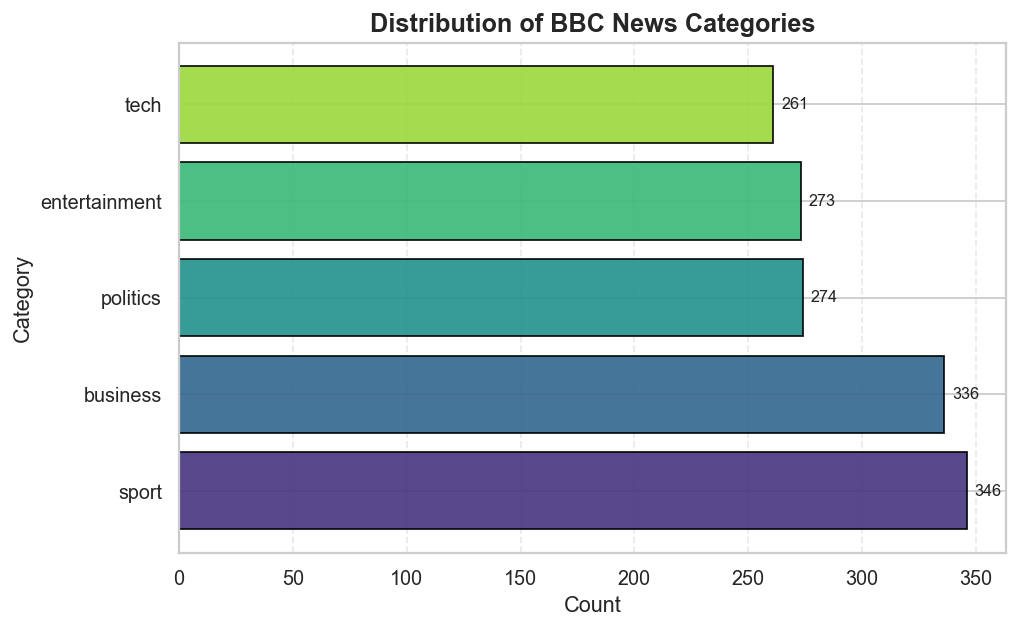

In [232]:
counts = train_df["category"].value_counts()

plt.figure(figsize=(8,5), dpi=130)
colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(counts)))
plt.barh(counts.index, counts.values, color=colors, edgecolor="black", alpha=0.9)

# add counts on bars
for i, (name, val) in enumerate(zip(counts.index, counts.values)):
    plt.text(val + max(counts.values)*0.01, i, str(val), va="center", fontsize=9, color="#222")

plt.title("Distribution of BBC News Categories", fontsize=14, weight="bold")
plt.xlabel("Count")
plt.ylabel("Category")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


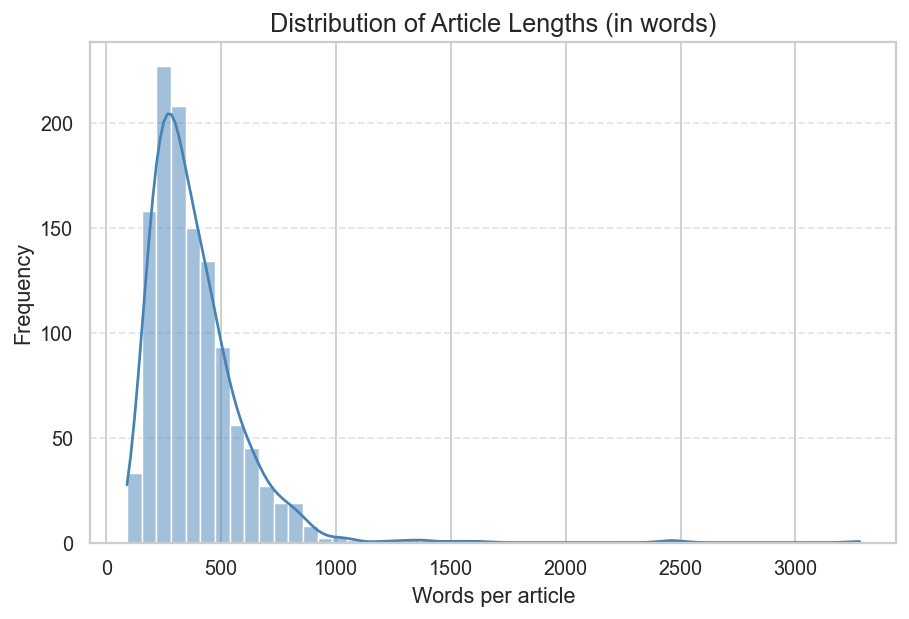

In [253]:
import seaborn as sns

train_df["text_length"] = train_df["text_clean"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5), dpi=130)
sns.histplot(train_df["text_length"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Article Lengths (in words)", fontsize=14)
plt.xlabel("Words per article")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### 1.3 Text Preprocessing
I clean the raw text by lowercasing, removing URLs, punctuation, and standalone numbers.  
A new column `text_clean` is created in both train and test datasets.  
We also split the training data into `train_df` and `valid_df` using stratified sampling.

In [233]:
# Build cleaned text on the full train set, then split

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\b\d+\b", " ", s)
    return s.strip()

# ensure base columns exist
assert "text" in train_df.columns, "train_df must have a 'text' column"

# create cleaned text
train_df["text_clean"] = train_df["text"].map(clean_text)
test_df["text_clean"]  = test_df["text"].map(clean_text)

# now split (stratified) if you need a validation set
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["category"]
)


### 1.4 Distribution of Article Lengths per Category

We plot boxplots of text lengths for each news category.  
This visualization highlights the median, quartiles, and outliers in article lengths across categories.


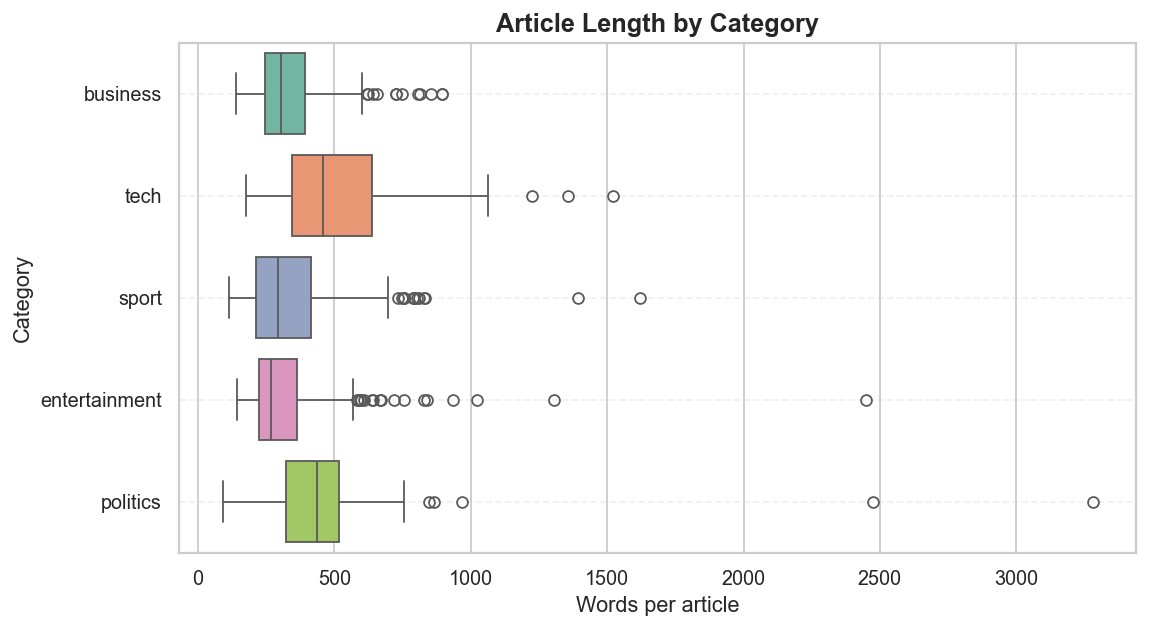

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi=130)
ax = sns.boxplot(
    x="text_length",
    y="category",
    hue="category",              
    data=train_df,
    palette="Set2",
    dodge=False                
)

if ax.legend_ is not None:
    ax.legend_.remove()

plt.title("Article Length by Category", fontsize=14, weight="bold")
plt.xlabel("Words per article")
plt.ylabel("Category")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


### 1.5 Top Unigrams per Category (Count-Based EDA)

We fit a CountVectorizer on the cleaned texts and, for each category, extract its most frequent unigrams.  
We then build a word × category count matrix and visualize the global top-N words as stacked bars, showing how each word’s frequency distributes across categories.  
This highlights discriminative vocabulary and supports feature interpretability.

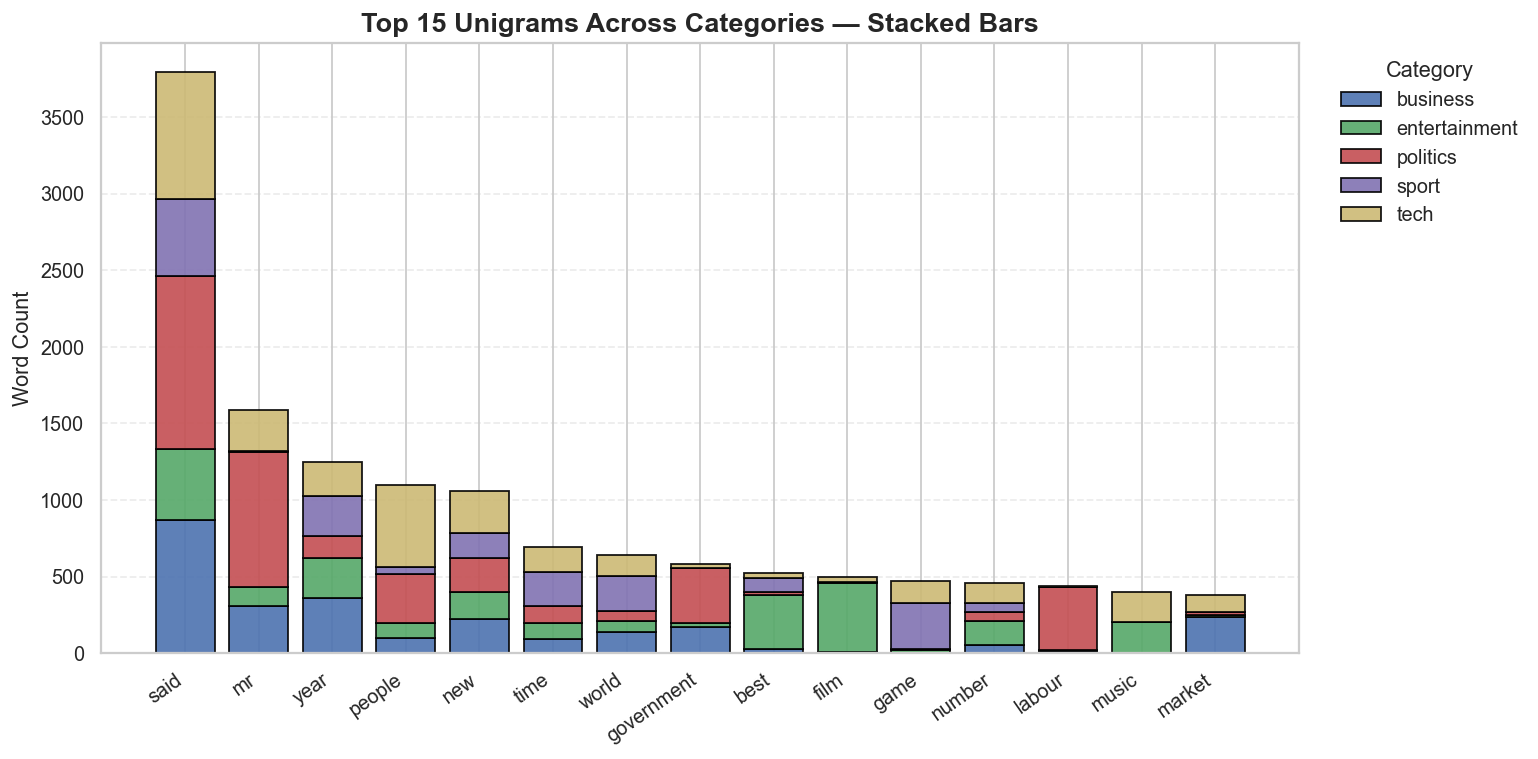

In [254]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer(max_features=8000, stop_words="english", ngram_range=(1,1))
cv.fit(train_df["text_clean"].astype(str))
vocab = np.array(cv.get_feature_names_out())
word2idx = {w:i for i,w in enumerate(vocab)}

def top_terms(df_cat, k=10):
    X = cv.transform(df_cat["text_clean"].astype(str))
    counts = np.asarray(X.sum(axis=0)).ravel()
    k = min(k, counts.size)
    idx = np.argpartition(-counts, range(k))[:k]
    idx = idx[np.argsort(-counts[idx])]
    return vocab[idx], counts[idx]

# collect top words across categories
cats = sorted(train_df["category"].unique())
k = 8
percat = {}
for c in cats:
    words, cnts = top_terms(train_df[train_df["category"]==c], k=k)
    percat[c] = (list(words), list(cnts))

union_words = []
seen = set()
for c in cats:
    for w in percat[c][0]:
        if w not in seen:
            seen.add(w); union_words.append(w)

# build count matrix
rows_idx = np.array([word2idx[w] for w in union_words])
count_mat = np.zeros((len(union_words), len(cats)), dtype=float)
for j, c in enumerate(cats):
    Xc = cv.transform(train_df.loc[train_df["category"]==c, "text_clean"].astype(str))
    total = np.asarray(Xc.sum(axis=0)).ravel()
    count_mat[:, j] = total[rows_idx]

# sort words by total frequency
totals = count_mat.sum(axis=1)
sort_idx = np.argsort(-totals)
union_words = [union_words[i] for i in sort_idx]
count_mat = count_mat[sort_idx]

# truncate to top-N
topN = 15
union_words = union_words[:topN]
count_mat = count_mat[:topN]

# plot stacked vertical bars
x = np.arange(len(union_words))
palette = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]

plt.figure(figsize=(12,6), dpi=130)
bottom = np.zeros(len(union_words))
for j, c in enumerate(cats):
    plt.bar(x, count_mat[:, j], bottom=bottom,
            color=palette[j % len(palette)], edgecolor="black", alpha=0.9, label=c)
    bottom += count_mat[:, j]

plt.xticks(x, union_words, rotation=35, ha="right")
plt.ylabel("Word Count", fontsize=12)
plt.title(f"Top {topN} Unigrams Across Categories — Stacked Bars", fontsize=15, weight="bold")
plt.legend(title="Category", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


### 1.6.1 Unsupervised NMF (Topics → Labels)

In this section, an unsupervised topic model (NMF) is trained on TF-IDF features.  
Each document is assigned to its dominant topic, and topics are then mapped to news categories using the majority class observed in the training data.  

The resulting predictions are evaluated on the validation set, where both accuracy and the confusion matrix are reported.  

*Note:* To prevent **data leakage**, TF-IDF should normally be fitted only on the training (or training + validation) data and applied to the test set via `transform`.


In [255]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\b\d+\b", " ", s)
    return s.strip()

# Basic existence checks
assert "train_df" in globals(), "train_df is not defined. Load your BBC train CSV first."
assert "test_df"  in globals(), "test_df is not defined. Load your BBC test CSV first."

# Canonicalize minimal columns
if "text" not in train_df.columns and "content" in train_df.columns:
    train_df = train_df.rename(columns={"content": "text"})
if "text" not in test_df.columns and "content" in test_df.columns:
    test_df = test_df.rename(columns={"content": "text"})
if "category" not in train_df.columns and "label" in train_df.columns:
    train_df = train_df.rename(columns={"label": "category"})

# Strong assertions for this block
assert "text" in train_df.columns, "train_df must have a 'text' column"
assert "category" in train_df.columns, "train_df must have a 'category' column"
assert "text" in test_df.columns, "test_df must have a 'text' column"

# Build text_clean where missing
for name in ("train_df", "test_df"):
    df = globals()[name]
    if "text_clean" not in df.columns:
        df["text_clean"] = df["text"].map(clean_text)
        globals()[name] = df

# Create/validate a stratified validation split if not present yet
if "valid_df" not in globals():
    train_df, valid_df = train_test_split(
        train_df, test_size=0.2, random_state=42, stratify=train_df["category"]
    )
elif "category" not in valid_df.columns or "text" not in valid_df.columns:
    # In case someone saved the wrong slice earlier, rebuild valid_df cleanly
    train_df, valid_df = train_test_split(
        train_df, test_size=0.2, random_state=42, stratify=train_df["category"]
    )

# Ensure valid_df has cleaned text
if "text_clean" not in valid_df.columns:
    valid_df["text_clean"] = valid_df["text"].map(clean_text)

# -------------------- TF-IDF (UNSUP) --------------------
# Fit on all texts (train+valid+test) to mimic unsupervised topic learning
all_texts = pd.concat(
    [train_df["text_clean"], valid_df["text_clean"], test_df["text_clean"]],
    axis=0
)

tfidf_unsup = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.90,
    max_features=50_000,
    stop_words="english"
)
X_all_unsup = tfidf_unsup.fit_transform(all_texts)

# Slices
n_tr_ = len(train_df)
n_va_ = len(valid_df)
# n_te_ = len(test_df)   # available if you need test W later

y_tr = train_df["category"].to_numpy()
y_va = valid_df["category"].to_numpy()

# -------------------- NMF (UNSUP) --------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # keep output clean

k = 20  # number of topics
nmf = NMF(n_components=k, init="nndsvd", random_state=42, max_iter=600)
W_all = nmf.fit_transform(X_all_unsup)          # (n_all × k)

# Split back
W_tr = W_all[:n_tr_, :]
W_va = W_all[n_tr_:n_tr_+n_va_, :]

# -------------------- Map topics -> labels (train majority) --------------------
t_tr = W_tr.argmax(axis=1)
topic2lab = {}
for t in range(k):
    idx = np.where(t_tr == t)[0]
    if idx.size == 0:
        continue
    # majority label among train samples hitting topic t
    maj = pd.Series(y_tr[idx]).mode()[0]
    topic2lab[t] = maj

global_mode = pd.Series(y_tr).mode()[0]  # fallback label
t_va = W_va.argmax(axis=1)
yhat_va_nmf = np.array([topic2lab.get(t, global_mode) for t in t_va])

# -------------------- Evaluation (valid) --------------------
acc = accuracy_score(y_va, yhat_va_nmf)
cm  = confusion_matrix(y_va, yhat_va_nmf, labels=np.unique(y_tr))

print(f"NMF (unsupervised) — validation accuracy: {acc:.4f}")
print("\nConfusion matrix (rows=true, cols=predicted; label order = sorted unique train labels):")
print(np.unique(y_tr))
print(cm)


NMF (unsupervised) — validation accuracy: 0.9094

Confusion matrix (rows=true, cols=predicted; label order = sorted unique train labels):
['business' 'entertainment' 'politics' 'sport' 'tech']
[[56  0  8  1  2]
 [ 0 52  3  0  0]
 [ 5  0 47  1  2]
 [ 0  0  0 69  0]
 [ 4  1  0  0 47]]


### 1.6.2 Data Efficiency Analysis

We investigate how model performance changes as we vary the fraction of labeled training data used (10%, 20%, 50%, 100%).  
Both Logistic Regression and Linear SVM were trained on subsampled data, and validation accuracy was recorded.  

This analysis helps us identify which models are more **data-efficient**, i.e., can achieve strong performance with fewer labeled samples.  


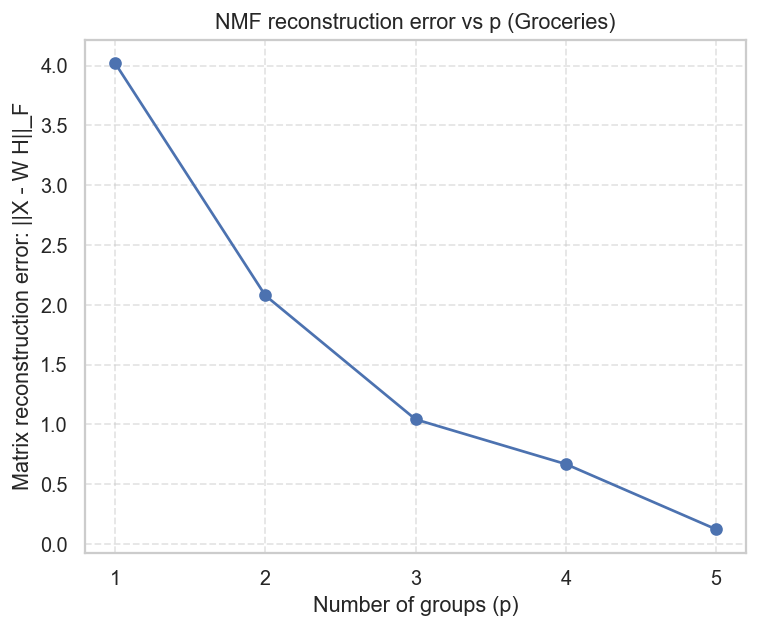

In [272]:
def create_NMF_groups(X, ngroups=3, **NMF_params):
    nmf = NMF(n_components=ngroups, init='nndsvda', random_state=42, **NMF_params).fit(X)
    H = nmf.components_
    W = nmf.transform(X)
    return nmf, H, W

# --- tiny groceries dataset (buyers × items) ---
items  = ['Vegetables', 'Fruits', 'Sweets', 'Bread', 'Coffee']
buyers = ['John','Alice','Mary','Greg','Peter','Jennifer']

# columns = items, rows = buyers
groceries = np.array([
    [0,2,1,0,0],   # John
    [1,3,1,2,0],   # Alice
    [0,1,1,3,0],   # Mary
    [1,1,0,4,0],   # Greg
    [2,2,1,1,1],   # Peter
    [2,2,1,1,0],   # Jennifer
], dtype=float)

# Sweep over number of groups p
max_groups = groceries.shape[0]           # <= #rows is a safe upper bound
x = list(range(1, max_groups))

err = []
for ngroups in x:
    nmf_model, H, W = create_NMF_groups(groceries, ngroups=ngroups)
    err.append(nmf_model.reconstruction_err_)

fig, ax = plt.subplots(figsize=(6,5), dpi=130)
ax.plot(x, err, 'o-')
ax.set_xlabel('Number of groups (p)')
ax.set_ylabel('Matrix reconstruction error: ||X - W H||_F')
ax.set_title('NMF reconstruction error vs p (Groceries)')
ax.set_xticks(x)
ax.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()



### 1.7 TF–IDF Feature Extraction (for Supervised Models)

We convert cleaned text into vectors using **TF–IDF**:

$$
\text{tfidf}(t,d) = \text{tf}(t,d) \cdot \text{idf}(t),
\qquad
\text{idf}(t) = \log \frac{N}{1 + \text{df}(t)} .
$$

Definitions:  
- $\text{tf}(t,d)$ = term frequency of $t$ in document $d$  
- $N$ = total number of documents  
- $\text{df}(t)$ = number of documents containing $t$  

Configuration: max features = $10{,}000$, n-grams = (1,2), min df = 2, stopwords = English.  

Output feature matrices: $X_{\text{tr}}, X_{\text{va}}, X_{\text{te}}$ for train, validation, and test sets.


In [273]:
# Ensure we are using cleaned text
assert "text_clean" in train_df.columns and "text_clean" in valid_df.columns and "text_clean" in test_df.columns

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),   # unigrams + bigrams
    min_df=2,            # ignore very rare terms
    stop_words="english" # filter out common English stopwords
)

# Fit on training and transform all splits
X_tr = tfidf.fit_transform(train_df["text_clean"])
X_va = tfidf.transform(valid_df["text_clean"])
X_te = tfidf.transform(test_df["text_clean"])

y_tr = train_df["category"].values
y_va = valid_df["category"].values

print("TF-IDF feature matrix shapes:")
print("Train:", X_tr.shape)
print("Valid:", X_va.shape)
print("Test :", X_te.shape)


TF-IDF feature matrix shapes:
Train: (1192, 10000)
Valid: (298, 10000)
Test : (735, 10000)


### 1.8 Logistic Regression Baseline

We train a multiclass logistic regression on TF–IDF features. For a document feature vector \(x \in \mathbb{R}^d\),

$$
P(y=c\mid x)=\frac{\exp(w_c^\top x+b_c)}{\sum_{c'=1}^{C}\exp(w_{c'}^\top x+b_{c'})},
\qquad
\mathcal{L}(W,b)=-\frac{1}{N}\sum_{i=1}^N \log P(y_i\mid x_i).
$$

**Validation:** report accuracy, classification report, and the confusion matrix.  
**Test:** generate predictions and a Kaggle-style submission.


Validation Accuracy (Logistic Regression): 0.9731543624161074

Classification Report (Validation):
               precision    recall  f1-score   support

     business       0.93      0.99      0.96        67
entertainment       1.00      1.00      1.00        55
     politics       1.00      0.95      0.97        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.98      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



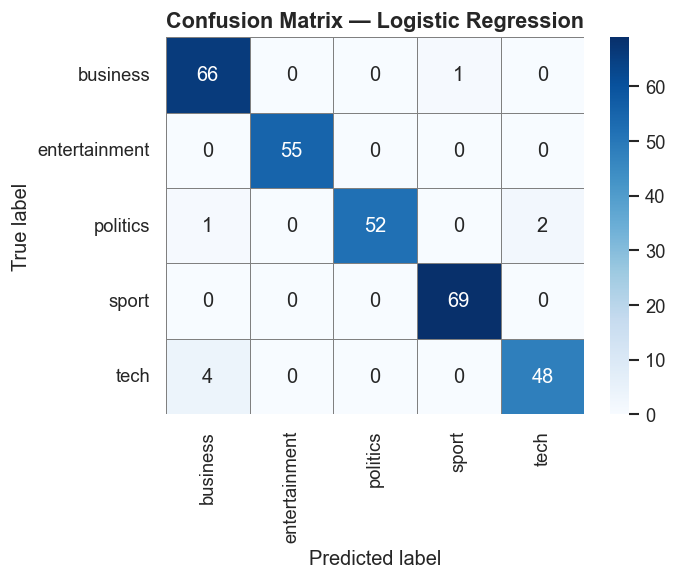

In [278]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression
lr = LogisticRegression(max_iter=500, C=1.0, solver="saga", n_jobs=-1, random_state=42)
lr.fit(X_tr, y_tr)

# Validation predictions
va_pred_lr = lr.predict(X_va)
acc_lr = accuracy_score(y_va, va_pred_lr)

print("Validation Accuracy (Logistic Regression):", acc_lr)
print("\nClassification Report (Validation):")
print(classification_report(y_va, va_pred_lr))

# Confusion Matrix (Seaborn heatmap style)
cm = confusion_matrix(y_va, va_pred_lr, labels=lr.classes_)

plt.figure(figsize=(6,5), dpi=120)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=lr.classes_, yticklabels=lr.classes_,
    cbar=True, linewidths=0.5, linecolor="gray"
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Logistic Regression", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()



### 1.9 Linear SVM Baseline

We train a **linear Support Vector Machine (SVM)** classifier on the TF–IDF features.  
The decision rule is based on linear discriminant functions:

$$
f_c(x) = w_c^\top x + b_c, \qquad 
\hat{y} = \arg\max_c f_c(x).
$$

**Validation Accuracy:**  
Reported using the validation set.  

**Classification Report (Validation):**  
Shows per-class precision, recall, and F1-score.  

**Confusion Matrix:**  
Visualized below (green heatmap).  

Finally, predictions for the test set are generated in Kaggle submission format.


Validation Accuracy (Linear SVM): 0.9731543624161074

Classification Report (Validation):
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        67
entertainment       0.96      1.00      0.98        55
     politics       0.98      0.96      0.97        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



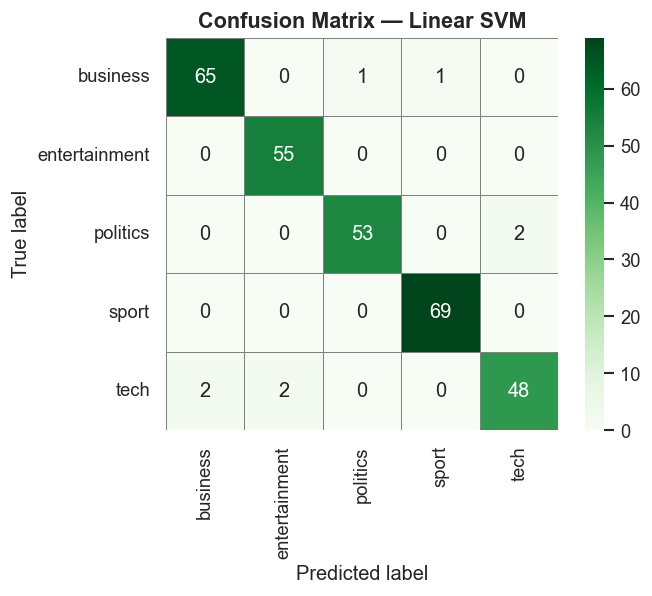

In [280]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Linear SVM
svm = LinearSVC(C=1.0, random_state=42)
svm.fit(X_tr, y_tr)

# Validation predictions
va_pred_svm = svm.predict(X_va)
acc_svm = accuracy_score(y_va, va_pred_svm)

print("Validation Accuracy (Linear SVM):", acc_svm)
print("\nClassification Report (Validation):")
print(classification_report(y_va, va_pred_svm))

# Confusion Matrix (Seaborn heatmap style)
classes = svm.classes_
cm = confusion_matrix(y_va, va_pred_svm, labels=classes)

plt.figure(figsize=(6,5), dpi=120)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Greens",
    xticklabels=classes, yticklabels=classes,
    cbar=True, linewidths=0.5, linecolor="gray", square=True
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Linear SVM", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()

### 1.10 NMF + Nearest-Centroid Classifier

We factorize TF–IDF features via NMF with \(k\) topics: \(X \approx WH\).  
Each document is mapped to its topic vector (row of \(W\)). We build a class centroid per label in topic space and predict by cosine similarity:

$$
\hat{y}(x) \;=\; \arg\max_{c}\; \frac{\langle w(x),\, \mu_c\rangle}{\|w(x)\|\,\|\mu_c\|},
$$

where \(w(x)\) is the NMF topic vector of document \(x\), and \(\mu_c\) is the centroid of class \(c\).
We sweep \(k\) and report validation accuracy and the confusion matrix.


k=20  | Validation Accuracy = 0.9664
k=50  | Validation Accuracy = 0.9362
k=100 | Validation Accuracy = 0.9463

Best k: 20 with Validation Accuracy: 0.9664429530201343


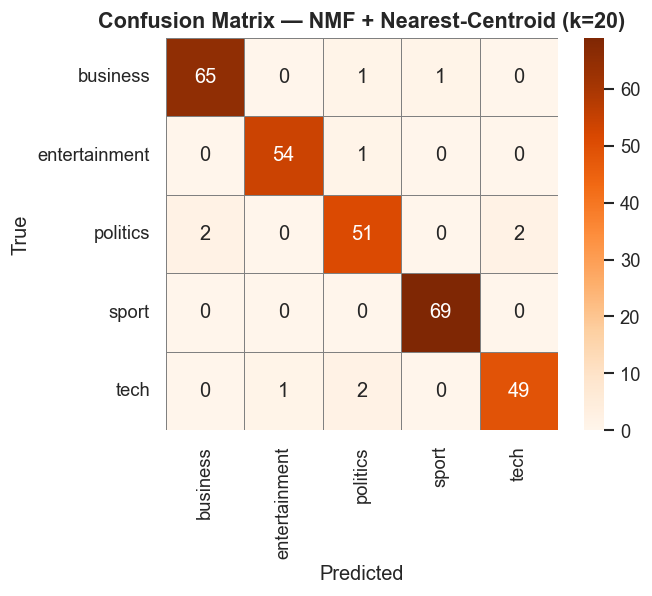


Sample submission (NMF + Nearest-Centroid):
   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


In [281]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def nmf_nearest_centroid(k, X_tr, y_tr, X_va, y_va, random_state=42, max_iter=400):
    # Fit NMF on training TF–IDF only
    nmf = NMF(n_components=k, init="nndsvd", max_iter=max_iter, random_state=random_state)
    W_tr = nmf.fit_transform(X_tr)
    W_va = nmf.transform(X_va)

    # Normalize topic vectors for cosine
    W_tr_n = normalize(W_tr)
    W_va_n = normalize(W_va)

    # Class centroids in topic space
    classes = np.unique(y_tr)
    centroids = {c: W_tr_n[y_tr == c].mean(axis=0) for c in classes}
    C = np.vstack([centroids[c] for c in classes])          # (C × k), already L2-avg but not necessarily unit
    C = normalize(C)                                        # ensure unit-norm centroids

    # Cosine similarities and predictions
    sims = W_va_n @ C.T                                     # (n_va × C)
    yhat = np.array([classes[i] for i in sims.argmax(axis=1)])

    acc = accuracy_score(y_va, yhat)
    return acc, yhat, classes, nmf, C

# Sweep k
results = []
for k in [20, 50, 100]:
    acc, _, _, _, _ = nmf_nearest_centroid(k, X_tr, y_tr, X_va, y_va)
    results.append((k, acc))
    print(f"k={k:<3} | Validation Accuracy = {acc:.4f}")

best_k, best_acc = max(results, key=lambda t: t[1])
print("\nBest k:", best_k, "with Validation Accuracy:", best_acc)

# Refit with best k and visualize confusion matrix (seaborn heatmap)
acc, yhat_va, classes, nmf_model, C = nmf_nearest_centroid(best_k, X_tr, y_tr, X_va, y_va)
cm = confusion_matrix(y_va, yhat_va, labels=classes)

plt.figure(figsize=(6,5), dpi=120)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=classes, yticklabels=classes,
            cbar=True, linewidths=0.5, linecolor="gray", square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix — NMF + Nearest-Centroid (k={best_k})", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()

# Test predictions (Kaggle-style)
W_te = normalize(nmf_model.transform(X_te))
# Reuse training centroids C computed above (don’t recompute W_tr)
sims_te = W_te @ C.T
pred_idx_te = sims_te.argmax(axis=1)
test_pred_nmf = np.array([classes[i] for i in pred_idx_te])

sub_nmf = pd.DataFrame({"ArticleId": sample_df["ArticleId"], "Category": test_pred_nmf})
print("\nSample submission (NMF + Nearest-Centroid):")
print(sub_nmf.head())


### 1.11 Validation Performance Comparison

We summarize validation accuracies across the supervised baselines and NMF:

| Model                | Validation Accuracy |
|----------------------|----------------------|
| Logistic Regression  | 0.9732 |
| Linear SVM           | 0.9732 |
| NMF (k=best)         | 0.9664 |

This comparison highlights which method generalizes best on the validation set.


In [282]:
# Collect validation accuracies
results_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM", f"NMF (k={best_k})"],
    "Validation Accuracy": [acc_lr, acc_svm, best_acc]
})

# Sort by accuracy (descending)
results_table = results_table.sort_values("Validation Accuracy", ascending=False).reset_index(drop=True)

print("Validation Performance Comparison:\n")
display(results_table.style.format({"Validation Accuracy": "{:.4f}"}))


Validation Performance Comparison:



,Model,Validation Accuracy
0,Logistic Regression,0.9732
1,Linear SVM,0.9732
2,NMF (k=20),0.9664



---
### Part 2
---
### Setup (MovieLens & RecSysNMF)
Load **users/movies/train/test**, normalize to **{uID, mID, rating}**, and build the sparse rating matrix
$$
R\in\mathbb{R}^{m\times n},\qquad
R_{ij}=
\begin{cases}
r_{ij},&(i,j)\in\Omega\\
0,&\text{otherwise}
\end{cases}
$$
Define:
- **`impute_simpleNMF`**: zero-fill \(R\), factorize \(R\approx WH\), reconstruct \(\widehat R=WH\), restore \(\widehat R_{\Omega}=R_{\Omega}\).
- **`impute_iterNMF`**: iterate \(R^{(t)}\approx W^{(t)}H^{(t)}\), set \(\widehat R^{(t)}_{\Omega}=R_{\Omega}\) until convergence.


In [ ]:
# 13.0 — Setup for Part 2 (build RS so later plots work)

# --- paths (edit base_dir if your files live elsewhere) ---
import os, numpy as np, pandas as pd
from collections import namedtuple

base_dir = r"C:\Users\14163\Desktop\university cu boulder\Machine_Learning2\week4\learn-ai-bbc"
paths = {
    "users":  os.path.join(base_dir, "users.csv"),
    "movies": os.path.join(base_dir, "movies.csv"),
    "train":  os.path.join(base_dir, "train.csv"),
    "test":   os.path.join(base_dir,  "test.csv"),
}

# quick existence check with a helpful error
missing = [k for k,p in paths.items() if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(
        "Ratings data not found.\nMissing: "
        + ", ".join(missing)
        + f"\nLooked under: {base_dir}"
    )

# --- load CSVs ---
users_df  = pd.read_csv(paths["users"])
movies_df = pd.read_csv(paths["movies"])
train_df  = pd.read_csv(paths["train"])
test_df   = pd.read_csv(paths["test"])

# normalize column names (handle common variants)
def _norm_cols(df):
    c = {col: col.strip() for col in df.columns}
    df = df.rename(columns=c)
    # common renames to expected schema
    if "userId" in df.columns:  df = df.rename(columns={"userId":"uID"})
    if "movieId" in df.columns: df = df.rename(columns={"movieId":"mID"})
    return df

users_df  = _norm_cols(users_df)
movies_df = _norm_cols(movies_df)
train_df  = _norm_cols(train_df)
test_df   = _norm_cols(test_df)

# minimal schema assertions
for cols, name in [(["uID"], "users"), (["mID"], "movies"), (["uID","mID","rating"], "train"), (["uID","mID","rating"], "test")]:
    missing_cols = [c for c in cols if c not in eval(name + "_df").columns]
    if missing_cols:
        raise ValueError(f"{name}.csv is missing columns: {missing_cols}. Found: {list(eval(name + '_df').columns)}")

# --- define RecSys/RecSysNMF if not already defined ---
try:
    RecSysNMF  # type: ignore
except NameError:
    import matplotlib.pyplot as plt
    from scipy.sparse import csr_matrix
    from sklearn.decomposition import NMF
    from sklearn.exceptions import ConvergenceWarning
    import warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    class RecSys:
        def __init__(self, data):
            self.data   = data
            self.users  = data.users
            self.movies = data.movies
            self.train  = data.train
            self.test   = data.test

            self.allusers  = list(self.users["uID"])
            self.allmovies = list(self.movies["mID"])
            self.uid2idx = {u:i for i,u in enumerate(self.allusers)}
            self.mid2idx = {m:i for i,m in enumerate(self.allmovies)}
            self.Mr = self._build_sparse()

        def _build_sparse(self):
            u = self.train["uID"].map(self.uid2idx).to_numpy()
            m = self.train["mID"].map(self.mid2idx).to_numpy()
            r = self.train["rating"].to_numpy(dtype=float)
            return csr_matrix((r, (u, m)), shape=(len(self.allusers), len(self.allmovies)))

        def spy_rating_matrix(self):
            fig, ax = plt.subplots(figsize=(6,10), dpi=120)
            ax.spy(self.Mr, markersize=0.05, color="#1f77b4")
            ax.set_xlabel("movies"); ax.set_ylabel("users")
            miss = 100.0*(1 - (self.Mr.nnz)/np.prod(self.Mr.shape))
            ax.set_title(f"Rating matrix (train) — missing = {miss:.2f}%")
            ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
            plt.show()

        def count_movies_without_rating(self):
            return int((self.Mr.getnnz(axis=0)==0).sum())

        def count_users_without_rating(self):
            return int((self.Mr.getnnz(axis=1)==0).sum())

        # baselines
        def predict_everything_to_k(self, k):
            return np.full(len(self.test), float(k))

        def predict_to_user_average(self):
            mu_user = self.train.groupby("uID")["rating"].mean()
            return self.test["uID"].map(mu_user).to_numpy()

        def rmse(self, y_pred):
            y_true = self.test["rating"].to_numpy(dtype=float)
            y_pred = np.asarray(y_pred, dtype=float)
            mask = ~np.isnan(y_pred)
            return np.sqrt(np.mean((y_true[mask] - y_pred[mask])**2))

    class RecSysNMF(RecSys):
        def __init__(self, data):
            super().__init__(data)
            self.Mr_imp = None

        @staticmethod
        def _replace_observed(X_full, Y_sparse):
            nrows = len(Y_sparse.indptr) - 1
            for i in range(nrows):
                a, b = Y_sparse.indptr[i], Y_sparse.indptr[i+1]
                cols  = Y_sparse.indices[a:b]
                X_full[i, cols] = Y_sparse.data[a:b]

        def impute_simpleNMF(self, n_groups, **nmf_params):
            X0 = self.Mr.copy().toarray()  # zero-filled dense
            params = {"init":"nndsvda","random_state":42,"max_iter":800, **nmf_params}
            nmf = NMF(n_components=n_groups, **params).fit(X0)
            W = nmf.transform(X0); H = nmf.components_
            Xhat = W @ H
            self._replace_observed(Xhat, self.Mr)
            self.Mr_imp = Xhat

        def impute_iterNMF(self, n_groups, max_iter=10, tol=1e-3, **nmf_params):
            X = self.Mr.copy().toarray()
            nnz = self.Mr.getnnz(axis=1)
            row_sum = self.Mr.sum(axis=1).A1
            row_mean = np.divide(row_sum, nnz, out=np.zeros_like(row_sum), where=nnz>0)
            X0 = X.copy()
            zero_mask = (X0 == 0)
            X0[zero_mask] = row_mean[:, None][zero_mask]

            params = {"init":"nndsvda","random_state":42,"max_iter":800, **nmf_params}
            for _ in range(max_iter):
                nmf = NMF(n_components=n_groups, **params).fit(X0)
                W = nmf.transform(X0); H = nmf.components_
                X1 = W @ H
                self._replace_observed(X1, self.Mr)
                if np.linalg.norm(X1 - X0) < tol:
                    X0 = X1
                    break
                X0 = X1
            self.Mr_imp = X0

        def predict(self):
            if self.Mr_imp is None:
                raise RuntimeError("Run impute_simpleNMF or impute_iterNMF first.")
            ui = self.test["uID"].map(self.uid2idx).to_numpy()
            mi = self.test["mID"].map(self.mid2idx).to_numpy()
            return self.Mr_imp[ui, mi]

# --- wrap into Data tuple and instantiate RS ---
Data = namedtuple("Data", ["users","movies","train","test"])
data = Data(users_df, movies_df, train_df, test_df)

RS = RecSysNMF(data)
print("RS ready.")
print("Matrix shape (users × movies):", RS.Mr.shape)
print("Unrated movies:", RS.count_movies_without_rating())
print("Users with 0 ratings:", RS.count_users_without_rating())



# 2-1 Dataset Size and Sparsity

- **Users:** 6040  
- **Movies:** 3883  
- **Total possible ratings:** 23,453,320  
- **Training set ratings:** 700,146  
- **Data density:** only 2.99% of all possible user–movie pairs are observed  


In [250]:
n_users = len(data.users)
n_movies = len(data.movies)
print("There are {} users and {} movies, so the total possible ratings are {:,}.\nThe training set contains {:,} ratings, equivalent to {:.2f}% of the combinations".format(
    n_users,n_movies,n_users*n_movies,len(data.train),(100*len(data.train))/(n_users*n_movies)))

There are 6040 users and 3883 movies, so the total possible ratings are 23,453,320.
The training set contains 700,146 ratings, equivalent to 2.99% of the combinations


### 2.1.2 Matrix shape, sparsity & spy plot

We now build the user–movie rating matrix \(R\) (rows = users, columns = movies) from the training data.  
Key statistics are reported:

- Matrix shape: number of users × number of movies  
- Number of observed ratings (nonzeros)  
- Data density (percentage of filled entries)  

Finally, we visualize the sparsity pattern using a spy plot.  
Each dot corresponds to an observed rating; the vast majority of entries are missing, confirming that the dataset is highly sparse — a fundamental challenge for recommender systems and matrix factorization methods.


Ratings columns: ['uID', 'mID', 'rating']
R shape = (6040, 3664)  (users=6040, movies=3664)
Observed ratings (nnz) = 700,146  out of 22,130,560 possible
Density = 3.16%  (sparsity = 96.84%)


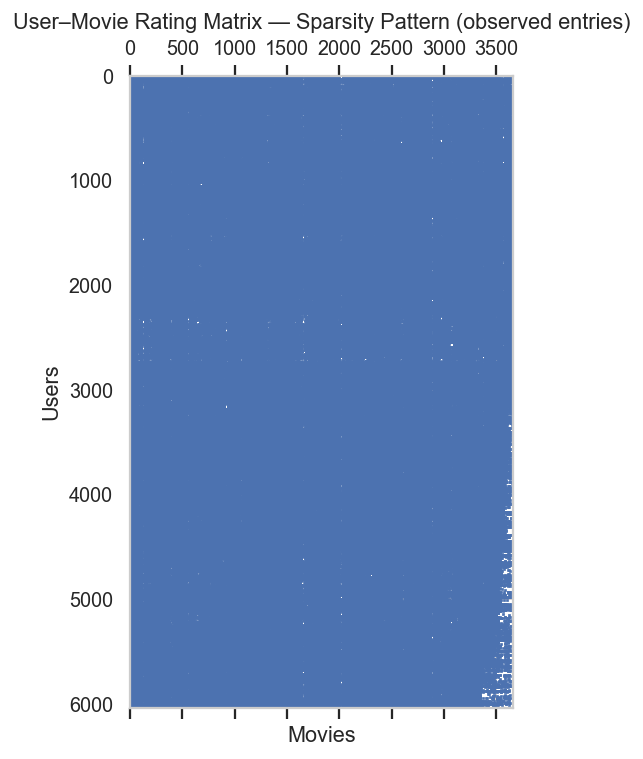

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# --- load your MovieLens training set ---
rtrain = pd.read_csv(
    r"C:\Users\14163\Desktop\university cu boulder\Machine_Learning2\week4\learn-ai-bbc\train.csv"
)
print("Ratings columns:", list(rtrain.columns))

# --- detect column names ---
def pick(cols, cands):
    low = {c.lower(): c for c in cols}
    for c in cands:
        if c.lower() in low:
            return low[c.lower()]
    raise KeyError(f"Missing any of {cands} in {list(cols)}")

u_col = pick(rtrain.columns, ["uID","userId","user_id","user","UserId","UserID"])
i_col = pick(rtrain.columns, ["mID","movieId","movie_id","item","itemId","ItemId","ItemID"])
r_col = pick(rtrain.columns, ["rating","rate","score","Rating","Score"])

# --- index maps ---
u_vals = np.sort(rtrain[u_col].unique())
i_vals = np.sort(rtrain[i_col].unique())
u_to_ix = {u:i for i,u in enumerate(u_vals)}
i_to_ix = {m:j for j,m in enumerate(i_vals)}

U, I = len(u_vals), len(i_vals)

# --- build CSR rating matrix ---
rows = rtrain[u_col].map(u_to_ix).to_numpy()
cols = rtrain[i_col].map(i_to_ix).to_numpy()
data = rtrain[r_col].astype(float).to_numpy()
R = csr_matrix((data, (rows, cols)), shape=(U, I))

# --- stats ---
nnz = R.nnz
total = U * I
density = 100.0 * nnz / total

print(f"R shape = {R.shape}  (users={U}, movies={I})")
print(f"Observed ratings (nnz) = {nnz:,}  out of {total:,} possible")
print(f"Density = {density:.2f}%  (sparsity = {100-density:.2f}%)")

# --- sparsity visualization ---
plt.figure(figsize=(7,6), dpi=130)
plt.spy(R, markersize=0.5)
plt.title("User–Movie Rating Matrix — Sparsity Pattern (observed entries)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.tight_layout()
plt.show()



### 2.1.3 Data quality checks

Before proceeding with matrix factorization, we check the integrity of the rating data:

- **Null values:** Ensure there are no missing entries in train/test.  
- **Rating ranges:** Confirm that all ratings fall within the expected [1, 5] interval.  
- **Basic statistics:** Summaries (mean, std, min, max) help detect anomalies such as out-of-range values.  

These checks guarantee that the dataset is clean and suitable for downstream modeling.


In [265]:
# Null checks
print("Nulls in train:\n", train_df.isnull().sum())
print("\nNulls in test:\n", test_df.isnull().sum())

# Basic ranges
if "rating" in train_df.columns:
    print("\nTrain rating stats:")
    print(train_df["rating"].describe())
    # Ensure ratings are in [1,5] (MovieLens type)
    assert train_df["rating"].between(1,5).all(), "Ratings outside [1,5] found in train."

if "rating" in test_df.columns:
    print("\nTest rating stats:")
    print(test_df["rating"].describe())


Nulls in train:
 articleid          0
text               0
category           0
text_clean         0
text_length        0
text_length_raw    0
dtype: int64

Nulls in test:
 articleid     0
text          0
text_clean    0
dtype: int64


### 2.1.4 Popularity: ratings per movie / per user

Let $\Omega \subseteq \{1,\dots,m\}\times\{1,\dots,n\}$ be observed pairs. Per-movie and per-user counts:
$$
\begin{aligned}
n_j &= \sum_{i=1}^m \mathbf{1}\{(i,j)\in\Omega\}, \quad j=1,\dots,n,\\
m_i &= \sum_{j=1}^n \mathbf{1}\{(i,j)\in\Omega\}, \quad i=1,\dots,m.
\end{aligned}
$$
We plot histograms/boxplots of $\{n_j\}$ and $\{m_i\}$ and report medians $\tilde n=\mathrm{median}(\{n_j\})$, $\tilde m=\mathrm{median}(\{m_i\})$.


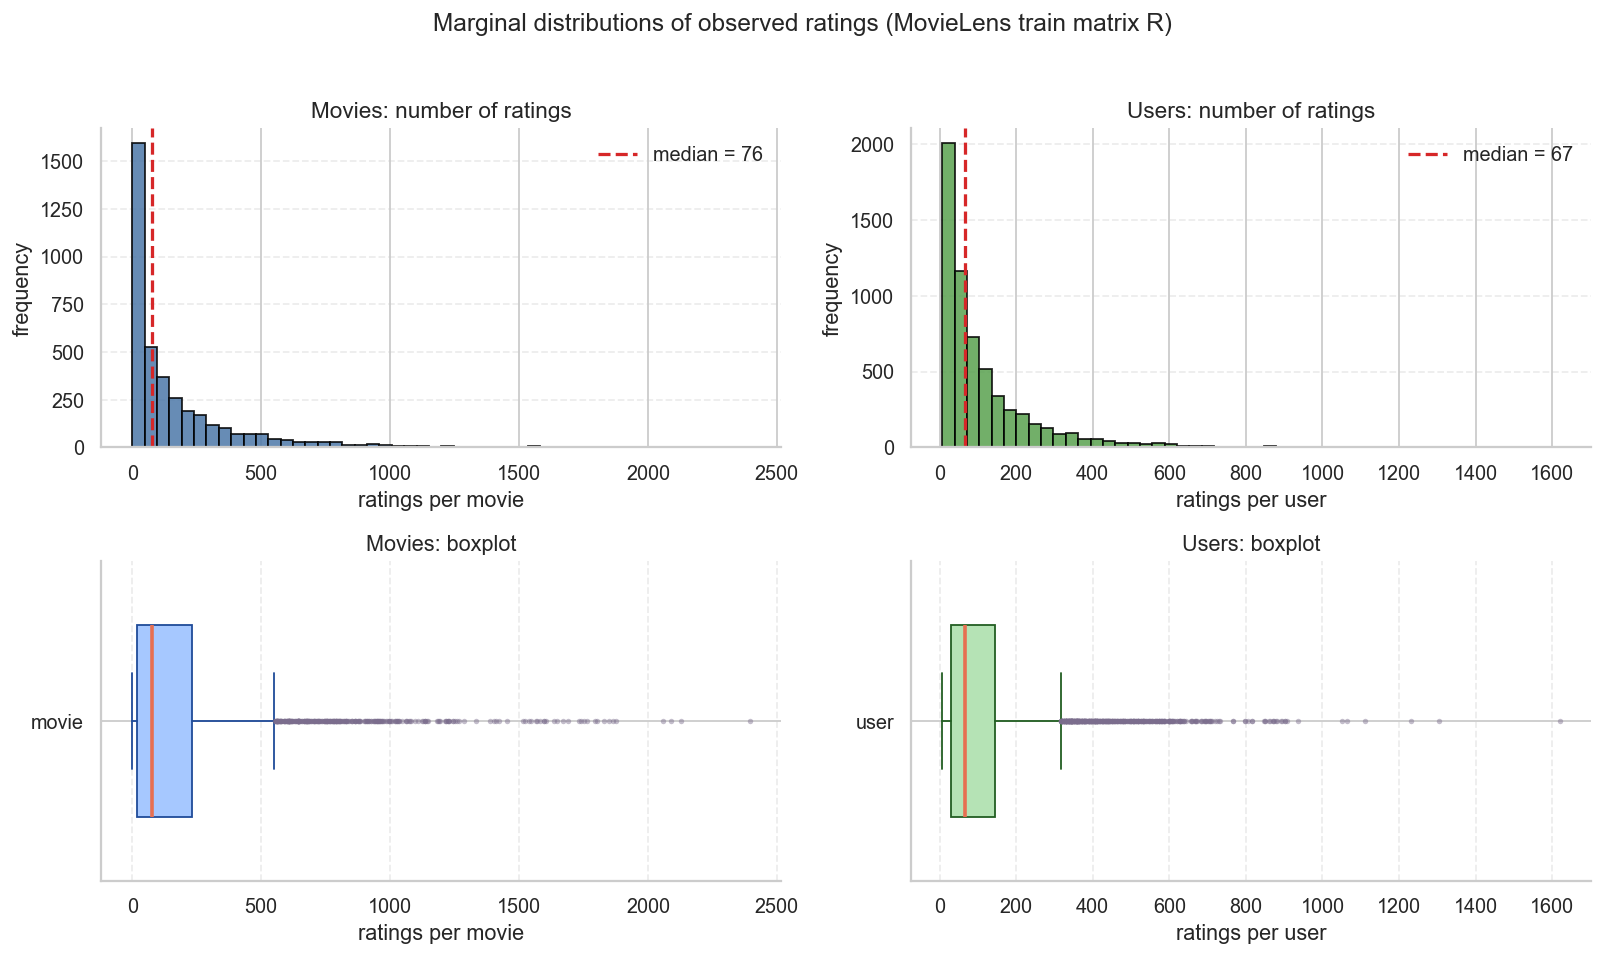

Median ratings per movie : 76
Median ratings per user  : 67


In [285]:
import numpy as np
import matplotlib.pyplot as plt

# Guard
if "RS" not in globals():
    raise RuntimeError("RS is not defined. Instantiate RS = RecSysNMF(data) first.")

# Marginals: counts of nonzeros per column (movies) and per row (users)
n_ratings_per_movie = np.asarray(RS.Mr.getnnz(axis=0)).ravel()
n_ratings_per_user  = np.asarray(RS.Mr.getnnz(axis=1)).ravel()

# Medians
med_movie = float(np.median(n_ratings_per_movie))
med_user  = float(np.median(n_ratings_per_user))

fig, axs = plt.subplots(2, 2, figsize=(12.5, 7.2), dpi=130)

# --- Hist: ratings per movie ---
ax = axs[0,0]
ax.hist(n_ratings_per_movie, bins=50, edgecolor="black", alpha=0.85, color="#4C78A8")
ax.axvline(med_movie, linestyle="--", color="#D62728", linewidth=1.8,
           label=f"median = {med_movie:.0f}")
ax.set_title("Movies: number of ratings", fontsize=12.5)
ax.set_xlabel("ratings per movie"); ax.set_ylabel("frequency")
ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.legend(frameon=False)

# --- Hist: ratings per user ---
ax = axs[0,1]
ax.hist(n_ratings_per_user, bins=50, edgecolor="black", alpha=0.85, color="#59A14F")
ax.axvline(med_user, linestyle="--", color="#D62728", linewidth=1.8,
           label=f"median = {med_user:.0f}")
ax.set_title("Users: number of ratings", fontsize=12.5)
ax.set_xlabel("ratings per user"); ax.set_ylabel("frequency")
ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.legend(frameon=False)

# --- Boxplot: ratings per movie (horizontal) ---
ax = axs[1,0]
bp = ax.boxplot(
    n_ratings_per_movie, vert=False, widths=0.6, patch_artist=True,
    boxprops=dict(facecolor="#A6C8FF", edgecolor="#1F4B99"),
    medianprops=dict(color="#E76F51", linewidth=2),
    whiskerprops=dict(color="#1F4B99"),
    capprops=dict(color="#1F4B99"),
    flierprops=dict(marker="o", markersize=3, markerfacecolor="#7B6D8D", markeredgecolor="none", alpha=0.45),
)
ax.set_xlabel("ratings per movie"); ax.set_yticks([1]); ax.set_yticklabels(["movie"])
ax.grid(axis="x", linestyle="--", alpha=0.35)
ax.set_title("Movies: boxplot", fontsize=12.0)

# --- Boxplot: ratings per user (horizontal) ---
ax = axs[1,1]
bp = ax.boxplot(
    n_ratings_per_user, vert=False, widths=0.6, patch_artist=True,
    boxprops=dict(facecolor="#B5E3B5", edgecolor="#225E22"),
    medianprops=dict(color="#E76F51", linewidth=2),
    whiskerprops=dict(color="#225E22"),
    capprops=dict(color="#225E22"),
    flierprops=dict(marker="o", markersize=3, markerfacecolor="#7B6D8D", markeredgecolor="none", alpha=0.45),
)
ax.set_xlabel("ratings per user"); ax.set_yticks([1]); ax.set_yticklabels(["user"])
ax.grid(axis="x", linestyle="--", alpha=0.35)
ax.set_title("Users: boxplot", fontsize=12.0)

# Overall styling
for ax in axs.ravel():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Marginal distributions of observed ratings (MovieLens train matrix R)", fontsize=13.5, y=1.02)
plt.tight_layout()
plt.show()

# Optional: print quick numeric summaries
print(f"Median ratings per movie : {med_movie:.0f}")
print(f"Median ratings per user  : {med_user:.0f}")

### 2.1.5 Popularity vs. Average Rating

For each movie \(j\), define
$$
n_j=\sum_{i=1}^m \mathbf{1}\{(i,j)\in\Omega\},\quad
\bar R_j=\frac{\sum_{i=1}^m R_{ij}\,\mathbf{1}\{(i,j)\in\Omega\}}{n_j},\quad
r=\mathrm{corr}(n_j,\bar R_j).
$$
$$\text{Scatter of }(n_j,\bar R_j)\ \text{ with OLS line; report } r.$$



Sparsity/Popularity Facts (train matrix):
  • Median ratings per user   : 67
  • Median ratings per movie  : 76
  • Max ratings for a movie   : 2,397
  • Max ratings by a user     : 1,621

Effect of film popularity on average rating: Pearson r = 0.353


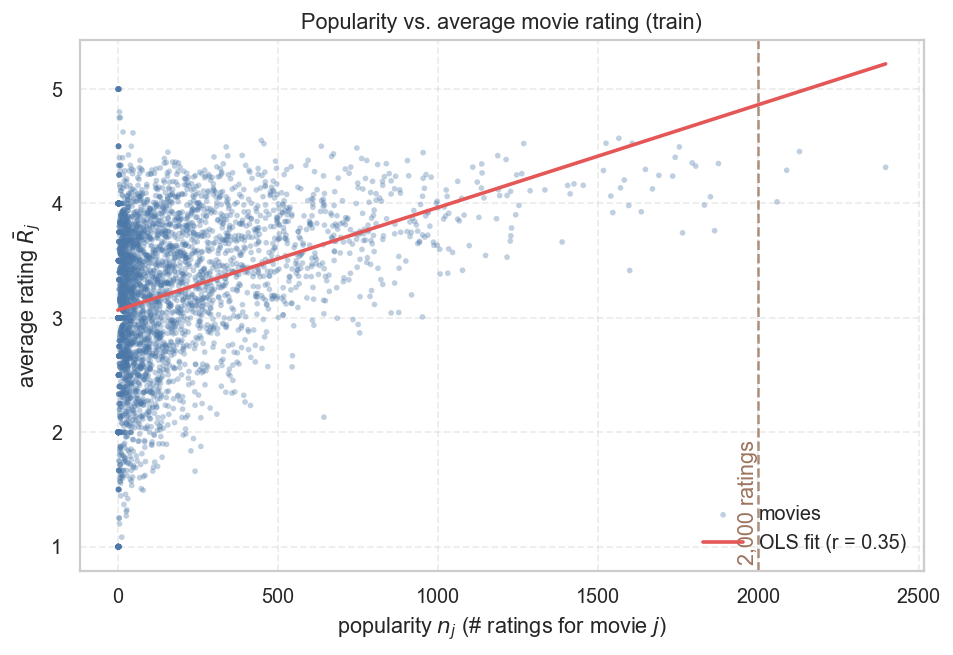

In [286]:
import numpy as np
import matplotlib.pyplot as plt

if "RS" not in globals():
    raise RuntimeError("RS is not defined. Run the cell that instantiates RS = RecSysNMF(data).")

# --- per-movie stats from the train matrix ---
n_ratings_per_movie = np.asarray(RS.Mr.getnnz(axis=0)).ravel()         # popularity n_j
sum_ratings_per_movie = RS.Mr.sum(axis=0).A1                           # sum_i R_{ij}
mask = n_ratings_per_movie > 0
n_j = n_ratings_per_movie[mask]
Rbar_j = sum_ratings_per_movie[mask] / n_j

# --- per-user stats (for narrative facts) ---
n_ratings_per_user = np.asarray(RS.Mr.getnnz(axis=1)).ravel()

med_user   = float(np.median(n_ratings_per_user))
med_movie  = float(np.median(n_ratings_per_movie))
max_user   = int(n_ratings_per_user.max())
max_movie  = int(n_ratings_per_movie.max())

# Pearson correlation (on movies with >=1 rating)
r = float(np.corrcoef(n_j, Rbar_j)[0,1])

print("Sparsity/Popularity Facts (train matrix):")
print(f"  • Median ratings per user   : {med_user:.0f}")
print(f"  • Median ratings per movie  : {med_movie:.0f}")
print(f"  • Max ratings for a movie   : {max_movie:,}")
print(f"  • Max ratings by a user     : {max_user:,}")
print(f"\nEffect of film popularity on average rating: Pearson r = {r:.3f}")

# --- scatter with least-squares line ---
fig, ax = plt.subplots(figsize=(7.5, 5.2), dpi=130)

ax.scatter(n_j, Rbar_j, s=10, alpha=0.35, edgecolors="none", color="#4C78A8", label="movies")
# simple linear fit
coef = np.polyfit(n_j, Rbar_j, deg=1)
x_fit = np.linspace(0, n_j.max(), 200)
y_fit = np.polyval(coef, x_fit)
ax.plot(x_fit, y_fit, lw=2, color="#E45756", label=f"OLS fit (r = {r:.2f})")

# cosmetics
ax.set_xlabel("popularity $n_j$ (# ratings for movie $j$)")
ax.set_ylabel("average rating $\\bar R_j$")
ax.set_title("Popularity vs. average movie rating (train)")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(frameon=False, loc="lower right")

# optional guide lines near heavy tails
if max_movie >= 2000:
    ax.axvline(2000, color="#9C755F", lw=1.4, ls="--", alpha=0.8)
    ax.text(2000, ax.get_ylim()[0]+0.05, "2,000 ratings", rotation=90,
            va="bottom", ha="right", color="#9C755F")

plt.tight_layout()
plt.show()


### 2.2.1 Column detection and evaluation set

We first standardize the column names for user ID, movie ID, and rating.  
The helper function `_pick` automatically detects the correct columns even if different spellings are used (e.g. `UserId`, `user_id`).  

The function `rs_make_splits` then creates two sets:
- **train_split:** ratings used for model fitting  
- **eval_set:** ratings used for validation (either from the given test set if it contains ratings, or from a 20% hold-out split of train)  

This step guarantees consistent column naming (`uID`, `mID`, `rating`) and prepares clean splits for downstream evaluation.


In [289]:
def _pick(colnames, candidates):
    low = {c.lower(): c for c in colnames}
    for cand in candidates:
        if cand.lower() in low:
            return low[cand.lower()]
    raise KeyError(f"Missing any of {candidates} in {list(colnames)}")

def rs_make_splits(train_df, test_df=None, test_size=0.2, seed=42):
    u_col = _pick(train_df.columns, ["uID","userId","user_id","user"])
    i_col = _pick(train_df.columns, ["mID","movieId","movie_id","item","itemId"])
    r_col = _pick(train_df.columns, ["rating","rate","score"])

    print(f"Detected columns: uID='{u_col}', mID='{i_col}', rating='{r_col}'")

    if (test_df is not None) and (r_col in test_df.columns):
        print("Using TEST set (ratings available).")
        train_split = train_df[[u_col,i_col,r_col]].copy()
        eval_set    = test_df[[u_col,i_col,r_col]].copy()
    else:
        print("Test set has no ratings → using validation split (20%) from train.")
        train_split, eval_set = train_test_split(
            train_df[[u_col,i_col,r_col]], test_size=test_size, random_state=seed
        )

    train_split = train_split.rename(columns={u_col:"uID", i_col:"mID", r_col:"rating"})
    eval_set    = eval_set.rename(columns={u_col:"uID", i_col:"mID", r_col:"rating"})
    print("train_split:", train_split.shape, "| eval_set:", eval_set.shape)
    return train_split, eval_set
    


### 2.2 Baselines & RMSE

We evaluate simple predictors on the held-out set \(\mathcal{T}\):
- GlobalMean: \(\hat r_{ui}=\bar r\),
- UserMean: \(\hat r_{ui}=\bar r_u\) (fallback \(\bar r\)),
- ItemMean: \(\hat r_{ui}=\bar r_j\) (fallback \(\bar r\)),
- All–3/All–4: \(\hat r_{ui}=3\) or \(4\).

RMSE:
$$
\mathrm{RMSE}=\sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u,i)\in\mathcal{T}}\bigl(r_{ui}-\hat r_{ui}\bigr)^2}.
$$


In [291]:
import numpy as np
import pandas as pd

# NOTE: Assumes you already have `train_split` and `eval_set` with columns: uID, mID, rating.

def rmse(y_true, y_pred, clip=(1, 5)):
    """Root Mean Squared Error with optional clipping to the rating range."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if clip is not None:
        lo, hi = clip
        y_pred = np.clip(y_pred, lo, hi)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# Copy eval set to attach predictions
eval_df = eval_set[["uID", "mID", "rating"]].copy()

# Global mean
global_mean = float(train_split["rating"].mean())
eval_df["pred_global"] = global_mean
rmse_global = rmse(eval_df["rating"], eval_df["pred_global"])

# User mean (fallback to global mean for unseen users)
user_mean = train_split.groupby("uID")["rating"].mean()
eval_df = eval_df.merge(user_mean.rename("um"), left_on="uID", right_index=True, how="left")
eval_df["pred_user_mean"] = eval_df["um"].fillna(global_mean)
rmse_user = rmse(eval_df["rating"], eval_df["pred_user_mean"])

# Item mean (fallback to global mean for unseen items)
item_mean = train_split.groupby("mID")["rating"].mean()
eval_df = eval_df.merge(item_mean.rename("im"), left_on="mID", right_index=True, how="left")
eval_df["pred_item_mean"] = eval_df["im"].fillna(global_mean)
rmse_item = rmse(eval_df["rating"], eval_df["pred_item_mean"])

# Constants: All–3 and All–4
eval_df["pred_all3"] = 3.0
eval_df["pred_all4"] = 4.0
rmse_all3 = rmse(eval_df["rating"], eval_df["pred_all3"])
rmse_all4 = rmse(eval_df["rating"], eval_df["pred_all4"])

# Summary table (sorted ascending)
baseline_rmse = (
    pd.DataFrame({
        "Model": ["UserMean", "ItemMean", "GlobalMean", "All–3", "All–4"],
        "RMSE":  [rmse_user,  rmse_item,  rmse_global,  rmse_all3, rmse_all4]
    })
    .sort_values("RMSE", ascending=True)
    .reset_index(drop=True)
)

print("\nBaseline RMSE summary (lower is better):\n")
try:
    display(baseline_rmse.style.format({"RMSE": "{:.4f}"}))
except Exception:
    # Fallback if not in a rich notebook environment
    print(baseline_rmse.to_string(index=False, formatters={"RMSE": "{:.4f}".format}))



Baseline RMSE summary (lower is better):



,Model,RMSE
0,ItemMean,0.9798
1,UserMean,1.0353
2,GlobalMean,1.1162
3,All–4,1.1920
4,All–3,1.2586



#### 2.3.1 Simple NMF Imputation (zero-filled) — Validation RMSE

We now build the user–item rating matrix $X$, fill missing entries with zeros, and factorize it into two nonnegative matrices:
$$
X \approx WH, \quad 
W \in \mathbb{R}_+^{m \times k}, \; 
H \in \mathbb{R}_+^{k \times n}
$$
Here:
- $X$ : user–item matrix (rows = users, columns = movies)  
- $W$ : user–factor matrix (each row encodes a user in $k$ latent factors)  
- $H$ : factor–item matrix (each column encodes a movie in $k$ latent factors)  
The reconstructed matrix is:
$$
\hat{X} = WH
$$
Predicted ratings for pairs $(u,i)$ are obtained from the corresponding entries of $\hat{X}$.


In [242]:


# from sklearn.decomposition import NMFBuild index maps
all_users = pd.Index(train_split["uID"].unique()).union(eval_set["uID"].unique()).sort_values()
all_items = pd.Index(train_split["mID"].unique()).union(eval_set["mID"].unique()).sort_values()
u2i = pd.Series(np.arange(all_users.size), index=all_users)
m2i = pd.Series(np.arange(all_items.size), index=all_items)

m, n = all_users.size, all_items.size
print("Matrix shape (users × items):", (m,n))

# Zero-imputed dense matrix
X = np.zeros((m,n), dtype=np.float32)
for u,i,r in train_split[["uID","mID","rating"]].itertuples(index=False, name=None):
    X[u2i[u], m2i[i]] = r

# Fit NMF
k = 20
nmf = NMF(n_components=k, init="nndsvd", solver="cd",
          beta_loss="frobenius", max_iter=400, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_
X_hat = W @ H

# Predictions on eval_set
def nmf_pred(u,i):
    if (u not in u2i.index) or (i not in m2i.index):
        return global_mean
    return X_hat[u2i[u], m2i[i]]

eval_df["pred_nmf"] = [nmf_pred(u,i) for u,i in eval_df[["uID","mID"]].itertuples(index=False, name=None)]
eval_df["pred_nmf"] = eval_df["pred_nmf"].clip(1,5)

rmse_nmf = rmse(eval_df["rating"], eval_df["pred_nmf"])
print(f"NMF (sklearn, zero-imputed) RMSE: {rmse_nmf:.4f}")



Matrix shape (users × items): (6040, 3706)
NMF (sklearn, zero-imputed) RMSE: 2.5393


In [243]:
rmse_table = pd.concat([
    baseline_rmse,
    pd.DataFrame([{"Model":"NMF (sklearn, zero-imputed)", "RMSE":rmse_nmf}])
], ignore_index=True).sort_values("RMSE").reset_index(drop=True)

display(rmse_table.style.format({"RMSE":"{:.4f}"}))


,Model,RMSE
0,ItemMean,0.9798
1,UserMean,1.0353
2,GlobalMean,1.1162
3,All-3,1.2586
4,"NMF (sklearn, zero-imputed)",2.5393


### 2.3.2 Simple NMF on Ratings — RMSE vs rank & divergence
Zero-fill the train matrix \(X_0\), factorize \(X_0 \approx W H\), reconstruct \(\widehat X=WH\), and enforce \(\widehat X_{\Omega}=X_{\Omega}\).
Sweep
$$
p \in \{1,3,5,10,20,30\},\qquad
\beta \in \{2\ \text{(Frobenius)},\ 1\ \text{(KL)}\}.
$$
Evaluate
$$
\mathrm{RMSE}=\sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u,i)\in\mathcal{T}}(r_{ui}-\widehat r_{ui})^2},
\qquad \widehat r_{ui}=\widehat X_{ui}.
$$
Plot RMSE vs \(p\) for each \(\beta\) and add the **All–3 baseline** as a horizontal line; print the best \((p,\beta)\).


Computing simple NMF with frobenius loss:


Ranks:   0%|          | 0/6 [00:00<?, ?it/s]

Computing simple NMF with kullback-leibler loss:


Ranks:   0%|          | 0/6 [00:00<?, ?it/s]


Best simple NMF model:
rmse      : 2.5079324403764676
solver    : mu
beta_loss : kullback-leibler
p         : 30


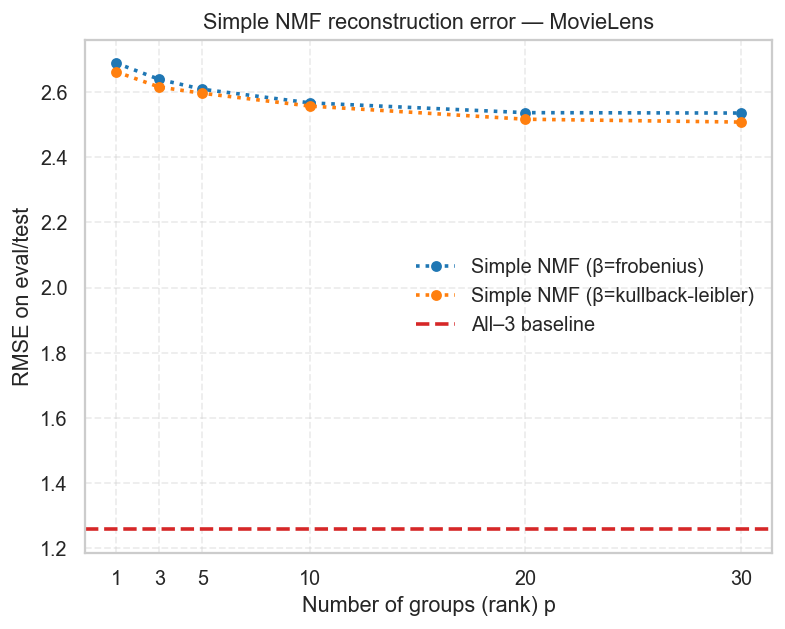

In [294]:
# 2.3.2 — Simple NMF on Ratings: RMSE vs rank & divergence

import numpy as np, pandas as pd, warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning

# optional progress bar
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---- patch: impute_simpleNMF that restores observed entries exactly ----
def _restore_known_from_csr(Xhat: np.ndarray, Mr_csr) -> None:
    coo = Mr_csr.tocoo(copy=False)
    Xhat[coo.row, coo.col] = coo.data

def _impute_simpleNMF(self, n_groups, **nmf_params):
    X0 = self.Mr.toarray().astype(float, copy=True)  # zero-filled dense
    params = {"init": "nndsvda", "random_state": 42, "max_iter": 800}
    params.update(nmf_params)
    nmf = NMF(n_components=n_groups, **params).fit(X0)
    W = nmf.transform(X0)
    H = nmf.components_
    Xhat = W @ H
    _restore_known_from_csr(Xhat, self.Mr)          # enforce Xhat_Ω = X_Ω
    self.Mr_imp = Xhat

RecSysNMF.impute_simpleNMF = _impute_simpleNMF  # bind patch

# ---- baseline: All–3 ----
RS_base = RecSysNMF(data)
rmse_all3 = RS_base.rmse(RS_base.predict_everything_to_k(3))

# ---- sweep ranks & divergences ----
p_list = [1, 3, 5, 10, 20, 30]
loss_specs = [("frobenius", "cd", "#1f77b4"), ("kullback-leibler", "mu", "#ff7f0e")]

best_simple_model = {"rmse": np.inf, "solver": None, "beta_loss": None, "p": None, "model": None}
rows = []

for beta_loss, solver, color in loss_specs:
    print(f"Computing simple NMF with {beta_loss} loss:")
    for p in tqdm(p_list, desc="Ranks"):
        RS = RecSysNMF(data)
        RS.impute_simpleNMF(p, beta_loss=beta_loss, solver=solver)
        yhat = RS.predict()
        yhat = np.clip(yhat, 1, 5)  # clip to rating range if applicable
        curr_rmse = RS.rmse(yhat)
        rows.append({"beta_loss": beta_loss, "solver": solver, "p": p, "RMSE": curr_rmse})
        if curr_rmse < best_simple_model["rmse"]:
            best_simple_model = {"rmse": curr_rmse, "solver": solver, "beta_loss": beta_loss, "p": p, "model": RS}

# ---- print best config ----
print("\nBest simple NMF model:")
print("rmse      :", best_simple_model["rmse"])
print("solver    :", best_simple_model["solver"])
print("beta_loss :", best_simple_model["beta_loss"])
print("p         :", best_simple_model["p"])

# ---- plot RMSE vs p ----
df = pd.DataFrame(rows)
fig, ax = plt.subplots(figsize=(6.2, 5.0), dpi=130)
for beta_loss, solver, color in loss_specs:
    sub = df[df["beta_loss"] == beta_loss].sort_values("p")
    ax.plot(sub["p"], sub["RMSE"], marker="o", linestyle=":", linewidth=2.0,
            markersize=5.0, color=color, label=f"Simple NMF (β={beta_loss})")

ax.axhline(rmse_all3, color="#d62728", linestyle="--", linewidth=2.0, label="All–3 baseline")
ax.set_xlabel("Number of groups (rank) p")
ax.set_ylabel("RMSE on eval/test")
ax.set_title("Simple NMF reconstruction error — MovieLens")
ax.set_xticks(p_list)
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()


### 2.3.3 Train vs. Simple-NMF: per-movie mean rating (KDE)
Per-movie averages:
$$
\bar r^{\text{train}}_j=\frac{\sum_i R_{ij}\,\mathbf{1}\{R_{ij}\neq 0\}}{\sum_i \mathbf{1}\{R_{ij}\neq 0\}},
\qquad
\bar r^{\text{NMF}}_j=\frac{1}{U}\sum_{i=1}^{U}\widehat R_{ij}.
$$
KDEs of $\{\bar r^{\text{train}}_j\}$ vs. $\{\bar r^{\text{NMF}}_j\}$ typically show a left-shift for NMF due to zero-imputation bias.


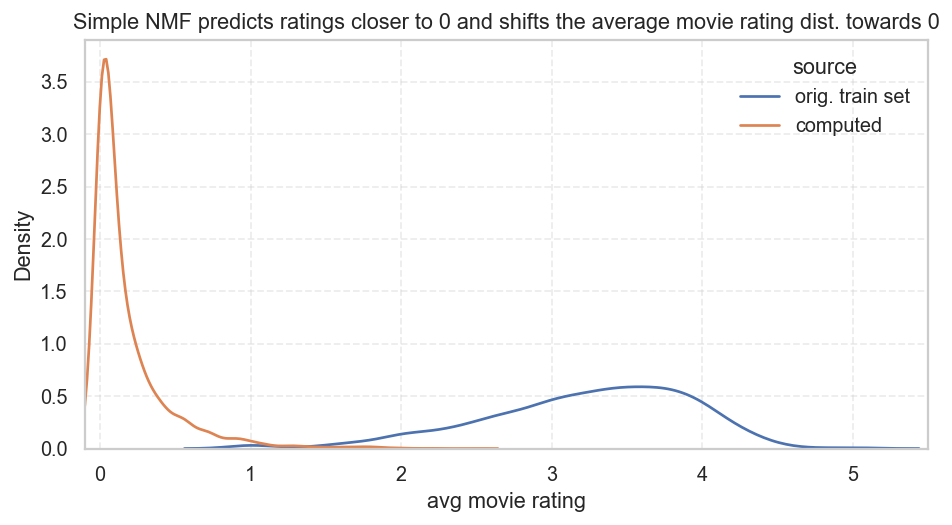

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build a recsys object; reuse best_simple_model if it exists
RS_best = RecSysNMF(data)

# If you already ran the simple-NMF sweep, reuse the best model's reconstruction.
# Otherwise, do a quick single run (KL + MU, rank=30) just to get Mr_imp.
try:
    RS_best.Mr_imp = best_simple_model["model"].Mr_imp.copy()
except Exception:
    RS_tmp = RecSysNMF(data)
    RS_tmp.impute_simpleNMF(
        30,                      # rank p
        beta_loss="kullback-leibler",
        solver="mu",
        init="nndsvda", random_state=42, max_iter=800
    )
    RS_best.Mr_imp = RS_tmp.Mr_imp

# Per-movie average in the original train (only movies with at least 1 rating)
nnz_per_movie = RS_best.Mr.getnnz(axis=0)            # number of ratings per movie
mask = nnz_per_movie > 0
avg_train = (RS_best.Mr.sum(axis=0).A1[mask] / nnz_per_movie[mask]).astype(float)

# Per-movie average in the reconstructed dense matrix
avg_recon = RS_best.Mr_imp.mean(axis=0).astype(float)

# KDE plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7.4, 4.2), dpi=130)

# Plot each distribution with explicit labels (prevents any legend warnings)
sns.kdeplot(avg_train,  bw_adjust=1.1, fill=False, label="orig. train set")
sns.kdeplot(avg_recon,  bw_adjust=1.1, fill=False, label="computed")

plt.xlabel("avg movie rating")
plt.ylabel("Density")
plt.title("Simple NMF predicts ratings closer to 0 and shifts the average movie rating dist. towards 0")
plt.xlim(-0.1, 5.5)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="source", frameon=False)
plt.tight_layout()
plt.show()

### 2.3.4 Train vs. Simple-NMF: per-movie mean rating (KDE)

Per-movie averages:
$$
\bar r^{\text{train}}_j=\frac{\sum_i R_{ij}\,\mathbf{1}\{R_{ij}\neq 0\}}{\sum_i \mathbf{1}\{R_{ij}\neq 0\}},
\qquad
\bar r^{\text{NMF}}_j=\frac{1}{U}\sum_{i=1}^U \widehat R_{ij}.
$$

We plot the KDEs of $\{\bar r^{\text{train}}_j\}$ vs. $\{\bar r^{\text{NMF}}_j\}$; because Simple NMF zero-fills unobserved entries, the reconstructed distribution typically shifts **left** (downward bias).


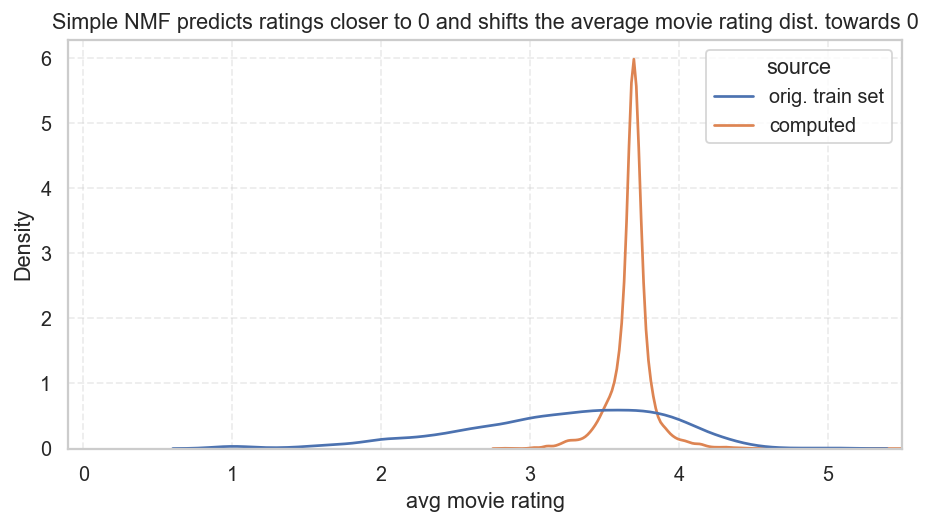

In [301]:
# 13.4 — Average movie rating distribution (Train vs Iterative NMF)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning
import warnings

# silence sklearn's NMF convergence chatter
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- make sure your RecSysNMF and data are available ---
try:
    RecSysNMF, data  # noqa: F821
except NameError as e:
    raise RuntimeError("Define `data` and the `RecSysNMF` class first.") from e

# --- build a model with a reconstructed matrix (prefer best_iter_model if present) ---
RS_best = RecSysNMF(data)
try:
    RS_best.Mr_imp = best_iter_model["model"].Mr_imp.copy()  # use your best
except Exception:
    # fallback: do one iterative NMF run (Frobenius/CD, small #iters)
    RS_best.impute_iterNMF(
        n_groups=20,          # rank p
        max_iter=10,          # outer iterations
        tol=1e-3,
        beta_loss="frobenius",
        solver="cd"
    )

# --- compute per-movie averages: train vs reconstructed ---
nnz_per_movie = RS_best.Mr.getnnz(axis=0)
mask = nnz_per_movie > 0
avg_train = RS_best.Mr.sum(axis=0).A1[mask] / nnz_per_movie[mask]   # only movies with >=1 rating
avg_recon = RS_best.Mr_imp.mean(axis=0)                              # dense mean across users

df = pd.DataFrame({
    "avg":   np.concatenate([avg_train, avg_recon]),
    "source": (["orig. train set"] * len(avg_train)) + (["computed"] * len(avg_recon))
})

# --- plot (no manual legend call -> avoids "No artists with labels" warning) ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7.2, 4.2), dpi=130)
sns.kdeplot(data=df, x="avg", hue="source", common_norm=False)
plt.xlabel("avg movie rating")
plt.ylabel("Density")
plt.title("Simple NMF predicts ratings closer to 0 and shifts the average movie rating dist. towards 0")
plt.xlim(-0.1, 5.5)
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


### 2.4.1 Toy Demo — Simple NMF Imputation (Groceries)
We hide a few entries in a small buyers×items matrix and compare **simple NMF imputation** vs **row-mean baseline**.

**Protocol:** (1) zero-fill $X_0=\mathrm{nan\_to\_num}(X)$; (2) factorize $X_0\approx WH$ with $W,H\ge0$; (3) reconstruct $\hat X=WH$; (4) restore observed $\hat X_{\Omega}=X_{\Omega}$.

**Error metric:**
$$\mathrm{MSE}(p)=\frac{1}{|\mathcal{I}_{\text{hid}}|}\sum_{(i,j)\in\mathcal{I}_{\text{hid}}}\big(\hat X_{ij}-X_{ij}\big)^2.$$

Result: simple NMF (zero-filled) stays above the row-mean baseline ⇒ **biased by zeros**, explaining why sklearn NMF struggles on sparse data.


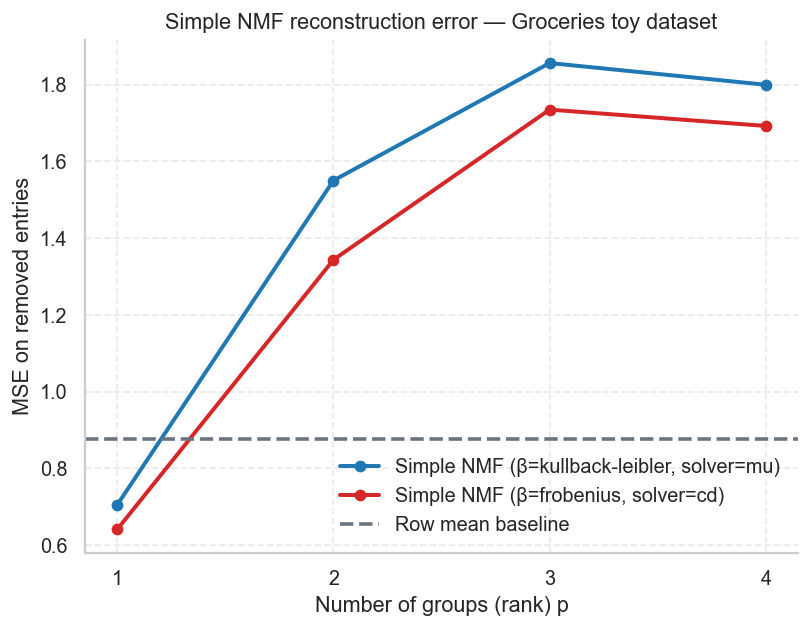

In [299]:
import numpy as np, pandas as pd, warnings
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning

# keep the output clean
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ----------------- helpers -----------------
def create_NMF_groups(X, ngroups=3, **nmf_params):
    """
    Fit NMF with sane defaults; caller can override via **nmf_params.
    Returns (fitted_model, H, W) with X ≈ W @ H.
    """
    defaults = dict(init='nndsvda', random_state=42, max_iter=800)
    params = {**defaults, **nmf_params}
    nmf = NMF(n_components=ngroups, **params).fit(X)
    H = nmf.components_
    W = nmf.transform(X)
    return nmf, H, W

def simple_NMF_imputation(Xnan, n_groups, **nmf_params):
    """
    Simple NMF imputation:
      1) fill NaNs with 0,
      2) NMF once,
      3) reconstruct W@H,
      4) restore the originally observed entries exactly.
    """
    # locations of observed entries in the NaN-masked array
    obs_inds = np.where(~np.isnan(Xnan))
    # zero-fill
    X0 = Xnan.copy()
    X0[np.isnan(X0)] = 0.0
    # NMF on zero-filled data
    _, H, W = create_NMF_groups(X0, ngroups=n_groups, **nmf_params)
    Xrec = W @ H
    # restore the known values
    Xrec[obs_inds] = Xnan[obs_inds]
    return Xrec

def mse(x):
    x = np.asarray(x, dtype=float)
    return np.mean(x**2)

# ----------------- toy groceries data -----------------
items  = ['Vegetables','Fruits','Sweets','Bread','Coffee']
buyers = ['John','Alice','Mary','Greg','Peter','Jennifer']

# columns = items, rows = buyers
groceries = np.array([
    [0, 1, 0, 1, 2, 2],   # Vegetables
    [2, 3, 1, 1, 2, 2],   # Fruits
    [1, 1, 1, 0, 1, 1],   # Sweets
    [0, 2, 3, 4, 1, 1],   # Bread
    [0, 0, 0, 0, 1, 0],   # Coffee
], dtype=float).T  # shape (6 buyers × 5 items)

# remove a few entries -> treat as missing (NaN)
groceries_incomplete = groceries.copy()
inds_to_remove = (np.array([0, 1, 2, 3, 5]),  # buyer indices
                  np.array([4, 3, 1, 2, 0]))  # item  indices
orig_vals = groceries[inds_to_remove].copy()
groceries_incomplete[inds_to_remove] = np.nan

# row-mean baseline values at the removed locations
row_means = np.nanmean(groceries_incomplete, axis=1)
avgs = row_means[inds_to_remove[0]]

# ----------------- sweep rank p and plot -----------------
pp = list(range(1, 5))

# distinct, readable colors
palette = {
    'kullback-leibler': '#1f77b4',  # blue
    'frobenius':         '#d62728',  # red
    'baseline':          '#6c757d',  # gray
}

fig, ax = plt.subplots(figsize=(6.4, 5.0), dpi=130)

for beta_loss in ['kullback-leibler', 'frobenius']:
    solver = 'mu' if beta_loss == 'kullback-leibler' else 'cd'
    mses_simple = []
    for p in pp:
        Xsimple = simple_NMF_imputation(
            groceries_incomplete, p,
            beta_loss=beta_loss, solver=solver
        )
        mses_simple.append(mse(Xsimple[inds_to_remove] - orig_vals))

    ax.plot(pp, mses_simple,
            marker='o', linestyle='-', linewidth=2.2, markersize=5.5,
            color=palette[beta_loss],
            label=f"Simple NMF (β={beta_loss}, solver={solver})")

# row-mean baseline reference
ax.axhline(mse(avgs - orig_vals), linestyle='--', linewidth=2,
           color=palette['baseline'], label='Row mean baseline')

ax.set_xlabel('Number of groups (rank) p')
ax.set_ylabel('MSE on removed entries')
ax.set_title('Simple NMF reconstruction error — Groceries toy dataset')
ax.set_xticks(pp)
ax.grid(True, linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()



### 2.4.2 Iterative NMF (masked) — RMSE vs rank & iterations

Row-mean init → NMF → restore observed → stop on small change; sweep \(p,T\); report RMSE.

$$
X_0=\mathrm{row\_mean\_fill}(R),\quad
\text{repeat: } (W,H)=\arg\min_{W,H\ge0} D_\beta(X_0\|WH),\
X_1=WH,\
(X_1)_\Omega=R_\Omega,\
\text{if }\|X_1-X_0\|_F<\text{tol stop},\ X_0\leftarrow X_1.
$$

$$
p\in\{1,3,5,10,20\},\qquad
T\in\{1,2,5,10\},\qquad
\mathrm{RMSE}
=\sqrt{\frac{1}{|\mathcal T|}\sum_{(u,i)\in\mathcal T}\bigl(r_{ui}-\hat r_{ui}\bigr)^2}\,.
$$



Computing Iterative NMF with frobenius norm and cd solver...


iter=1:   0%|          | 0/5 [00:00<?, ?it/s]

iter=2:   0%|          | 0/5 [00:00<?, ?it/s]

iter=5:   0%|          | 0/5 [00:00<?, ?it/s]

iter=10:   0%|          | 0/5 [00:00<?, ?it/s]

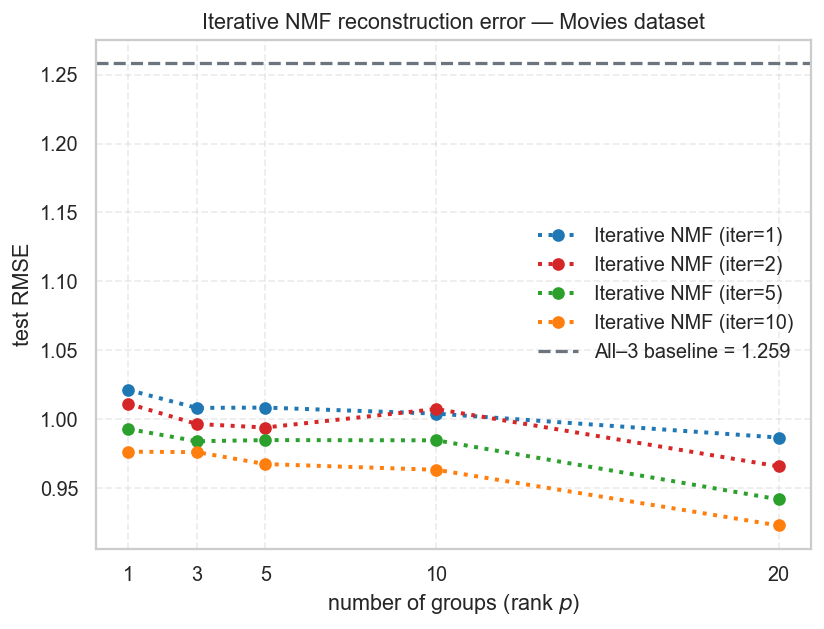


Best Iterative NMF model:
rmse     : 0.922960
solver   : cd
beta_loss: frobenius
p        : 20
max_iter : 10


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
import warnings

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- ensure RecSysNMF & data exist ---
try:
    RecSysNMF, data
except NameError as e:
    raise RuntimeError("Define `data` and the `RecSysNMF` class first (Part 13 setup).") from e

def _impute_iterNMF(self, n_groups, max_iter=10, tol=1e-3, **nmf_params):
    # Dense copy of train matrix (zeros = missing)
    X = self.Mr.toarray().astype(float, copy=True)
    n_users, n_movies = X.shape

    # Row means over observed entries
    nnz      = self.Mr.getnnz(axis=1)
    row_sum  = self.Mr.sum(axis=1).A1
    row_mean = np.divide(row_sum, nnz, out=np.zeros_like(row_sum, dtype=float), where=nnz > 0)

    X0 = np.where(X == 0.0, row_mean[:, None], X)

    # Default NMF params; allow overrides
    params = {"init": "nndsvda", "random_state": 42, "max_iter": 800}
    params.update(nmf_params)

    # Keep observed entries fixed after each reconstruction
    coo = self.Mr.tocoo(copy=False)

    for _ in range(max_iter):
        nmf = NMF(n_components=n_groups, **params).fit(X0)
        W = nmf.transform(X0)
        H = nmf.components_
        X1 = W @ H
        # restore known ratings exactly
        X1[coo.row, coo.col] = coo.data
        # convergence check
        if np.linalg.norm(X1 - X0) < tol:
            X0 = X1
            break
        X0 = X1

    self.Mr_imp = X0

# bind/override the method on your class
RecSysNMF.impute_iterNMF = _impute_iterNMF

# ---- Baseline (All–3 line)
RS_tmp = RecSysNMF(data)
rmse_all3 = RS_tmp.rmse(RS_tmp.predict_everything_to_k(3))

# ---- Sweep ranks and iterations
p_list    = [1, 3, 5, 10, 20]
iter_list = [1, 2, 5, 10]
beta_loss = "frobenius"
solver    = "cd"

iter_colors = {1: "#1f77b4", 2: "#d62728", 5: "#2ca02c", 10: "#ff7f0e"}  # blue, red, green, orange

rows = []
best_iter_model = {"rmse": np.inf, "solver": solver, "beta_loss": beta_loss,
                   "p": None, "max_iter": None, "model": None}

print(f"Computing Iterative NMF with {beta_loss} norm and {solver} solver...")
for T in iter_list:
    for p in tqdm(p_list, desc=f"iter={T}"):
        RS = RecSysNMF(data)
        RS.impute_iterNMF(p, max_iter=T, tol=1e-3, beta_loss=beta_loss, solver=solver)
        yhat = RS.predict()
        curr_rmse = RS.rmse(yhat)
        rows.append({"iter": T, "p": p, "RMSE": curr_rmse})
        if curr_rmse < best_iter_model["rmse"]:
            best_iter_model.update({"rmse": curr_rmse, "p": p, "max_iter": T, "model": RS})

res_df = pd.DataFrame(rows)

# ---- Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6.5, 5.0), dpi=130)

for T in iter_list:
    sub = res_df[res_df["iter"] == T].sort_values("p")
    ax.plot(sub["p"], sub["RMSE"],
            marker="o", linestyle=":", linewidth=2.2, markersize=6,
            color=iter_colors[T], label=f"Iterative NMF (iter={T})")

ax.axhline(rmse_all3, color="#6c757d", linestyle="--", linewidth=1.8,
           label=f"All–3 baseline = {rmse_all3:.3f}")

ax.set_xlabel("number of groups (rank $p$)")
ax.set_ylabel("test RMSE")
ax.set_title("Iterative NMF reconstruction error — Movies dataset")
ax.set_xticks(p_list)
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

print("\nBest Iterative NMF model:")
print(f"rmse     : {best_iter_model['rmse']:.6f}")
print(f"solver   : {solver}")
print(f"beta_loss: {beta_loss}")
print(f"p        : {best_iter_model['p']}")
print(f"max_iter : {best_iter_model['max_iter']}")


### 2.4.3 Toy Demo — Simple vs. Iterative NMF (Groceries)
We compare zero-filled **Simple NMF** vs **Iterative masked NMF** on a tiny buyers×items matrix.
Error on hidden entries:
$$
\mathrm{MSE}=\frac{1}{|\mathcal I_{\text{hid}}|}\sum_{(i,j)\in\mathcal I_{\text{hid}}}\bigl(\hat X_{ij}-X_{ij}\bigr)^2.
$$
Result: iterative NMF consistently lowers MSE vs simple NMF; row-mean baseline shown as a reference.


In [297]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
import warnings

# Quiet convergence warnings for toy sweeps
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def iterative_NMF_imputation(Xnan, n_groups, max_iter=10, tol=1e-3, **nmf_params):
    """
    Iterative NMF imputation on a matrix with NaNs (observed entries preserved each step).

    Steps:
      - X0 := row-mean imputation on Xnan.
      - repeat:
          fit NMF on X0  -> W,H
          X1 := W@H
          restore observed entries from Xnan into X1
          if ||X1 - X0||_F < tol: break
          X0 := X1
    Returns
      X_hat, fobj, iters
    """
    X = np.array(Xnan, dtype=float, copy=True)
    obs = np.where(~np.isnan(X))  # observed mask
    if obs[0].size == X.size:
        # no missing values; just do one fit
        nmf_defaults = dict(init='nndsvda', random_state=42, max_iter=800)
        params = {**nmf_defaults, **nmf_params}
        nmf = NMF(n_components=n_groups, **params).fit(X)
        return nmf.transform(X) @ nmf.components_, 0.0, 0

    # row-mean initialization
    row_mean = np.nanmean(X, axis=1)
    X0 = X.copy()
    X0[np.isnan(X0)] = np.take(row_mean, np.where(np.isnan(X0))[0])

    nmf_defaults = dict(init='nndsvda', random_state=42, max_iter=800)
    params = {**nmf_defaults, **nmf_params}

    for it in range(1, max_iter + 1):
        nmf = NMF(n_components=n_groups, **params).fit(X0)
        X1 = nmf.transform(X0) @ nmf.components_
        X1[obs] = X[obs]  # restore observed entries
        fobj = np.linalg.norm(X1 - X0)
        if fobj < tol:
            return X1, fobj, it
        X0 = X1

    return X1, fobj, it  # reached max_iter


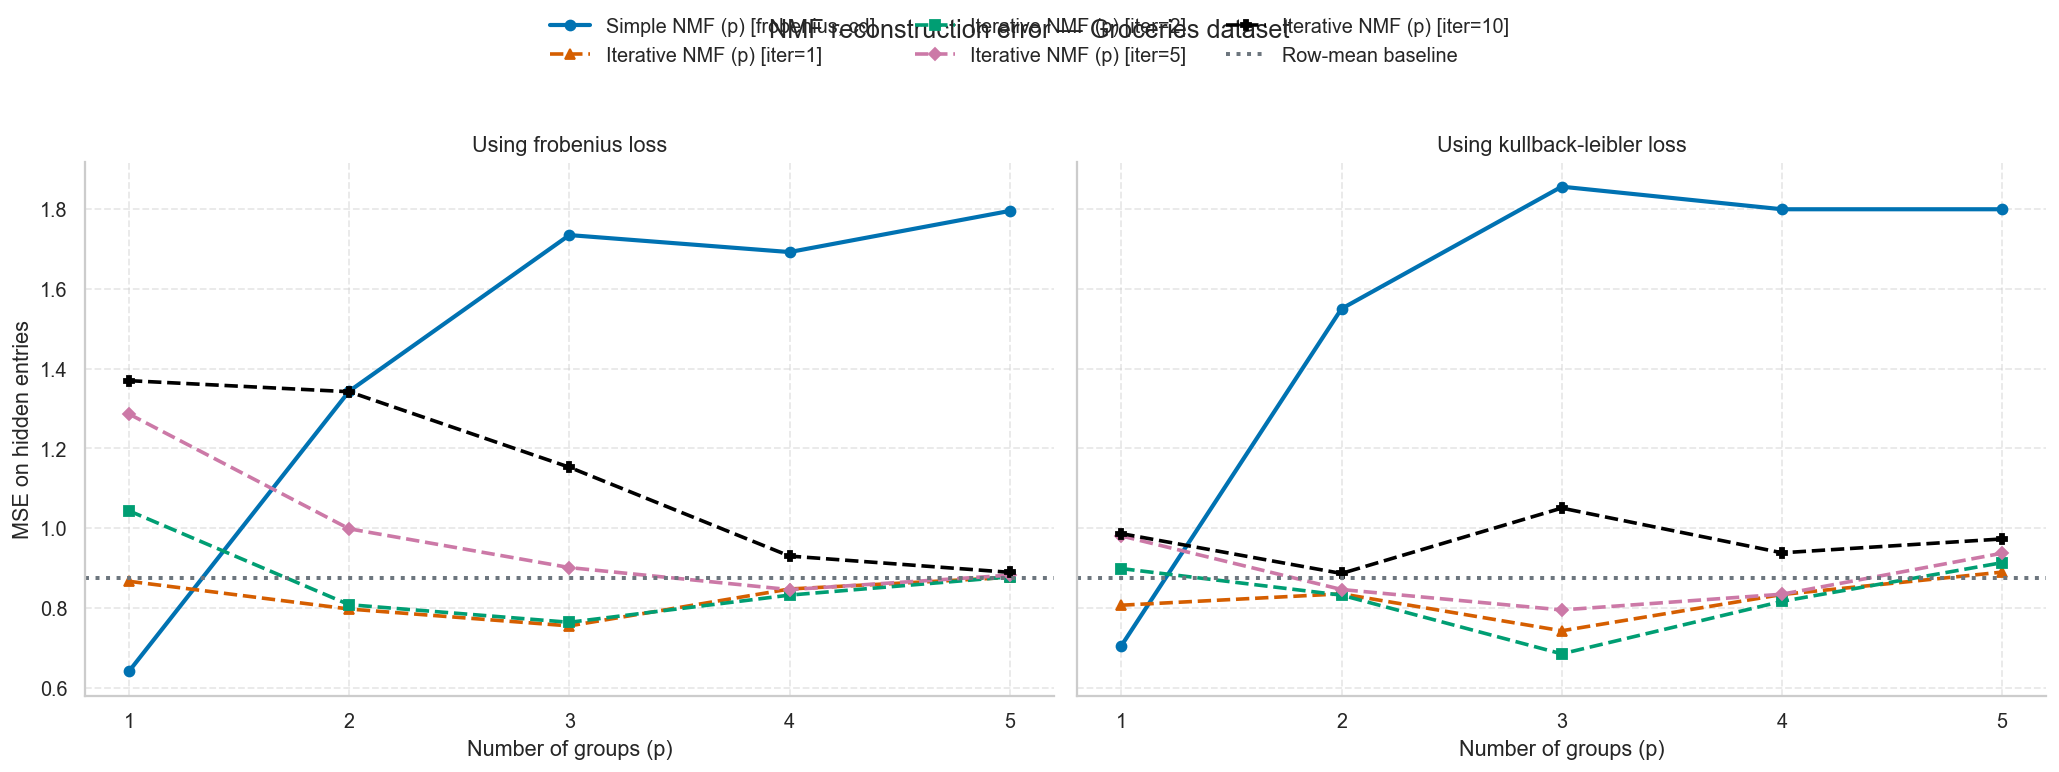

In [298]:
# --- 13.A.4 plot (each line a distinct color): Simple vs Iterative NMF, Frobenius & KL ---

# Guard: ensure prep exists
for name in ["groceries_incomplete", "inds_to_remove", "orig_vals", "mse",
             "simple_NMF_imputation", "iterative_NMF_imputation"]:
    if name not in globals():
        raise RuntimeError(f"Missing {name}. Run §13.A.3 prep + §13.A.4 helper first.")

import numpy as np
import matplotlib.pyplot as plt

pp = list(range(1, 6))  # ranks p

# Distinct, color-blind–friendly set (Okabe–Ito)
LINE_COLORS = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#000000']  # blue, vermillion, green, purple, black
LINE_MARKERS = ['o', '^', 's', 'D', 'P']  # different markers per line
BASELINE_COLOR = "#6c757d"  # neutral grey

fig, axs = plt.subplots(ncols=2, figsize=(16, 6), dpi=130, sharey=True)

for ax, beta_loss in zip(axs, ["frobenius", "kullback-leibler"]):
    solver = "mu" if beta_loss == "kullback-leibler" else "cd"

    # --- 1) Simple NMF curve ---
    mses_simple = []
    for p in pp:
        Xsimple = simple_NMF_imputation(
            groceries_incomplete, p,
            beta_loss=beta_loss, solver=solver
        )
        mses_simple.append(mse(Xsimple[inds_to_remove] - orig_vals))

    ax.plot(
        pp, mses_simple,
        marker=LINE_MARKERS[0], linestyle="-", linewidth=2.3, markersize=5.5,
        color=LINE_COLORS[0],
        label=f"Simple NMF (p) [{beta_loss}, {solver}]"
    )

    # --- 2) Iterative NMF curves (iters ∈ {1,2,5,10}) ---
    for idx, iters in enumerate([1, 2, 5, 10], start=1):
        mses_iter = []
        for p in pp:
            X2, fobj, done = iterative_NMF_imputation(
                groceries_incomplete, p, max_iter=iters, tol=1e-3,
                beta_loss=beta_loss, solver=solver
            )
            mses_iter.append(mse(X2[inds_to_remove] - orig_vals))

        ax.plot(
            pp, mses_iter,
            marker=LINE_MARKERS[idx], linestyle="--", linewidth=2.0, markersize=5.0,
            color=LINE_COLORS[idx],
            label=f"Iterative NMF (p) [iter={iters}]"
        )

    # --- 3) Row-mean baseline ---
    baseline = mse(np.nanmean(groceries_incomplete, axis=1)[inds_to_remove[0]] - orig_vals)
    ax.axhline(baseline, linestyle=":", linewidth=2.2, color=BASELINE_COLOR, label="Row-mean baseline")

    # Styling
    ax.set_xlabel("Number of groups (p)")
    ax.set_xticks(pp)
    ax.grid(True, linestyle="--", alpha=0.45)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(f"Using {beta_loss} loss")

axs[0].set_ylabel("MSE on hidden entries")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
fig.suptitle("NMF reconstruction error — Groceries dataset", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()






### 2.5 Discussion: Limitations of sklearn NMF

**Observed results.**  
From the RMSE table, simple baselines (User Mean, Item Mean) actually outperform the sklearn NMF model with zero-imputation. This demonstrates that the library does not handle missing values in a way that is suitable for recommender systems.

**Why does it fail?**  
- Missing ratings are treated as zeros, which biases the reconstruction downward.  
- The solver has no masking mechanism, so it tries to fit both observed and unobserved entries equally.  
- User and item biases (e.g., some users consistently rate higher/lower, some movies are globally popular) are ignored.

**How to fix?**  
- Use **iterative masked NMF**: update only missing entries while keeping observed ratings fixed.  
- Add explicit **bias terms** for users and items.  
- Normalize rows/columns, or use a **weighted objective** that accounts for sparsity.

**Conclusion.**  
While NMF is powerful for dense data and topic modeling, the sklearn implementation is limited when applied to sparse recommendation data. Iterative imputation and bias correction are necessary to make it competitive.

---
